# Import Libraries

In [1]:
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import lars_path
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import scipy.stats as stats

# Model Evaluation

## R-Squared

R-squared measures the "percentage of variance explained by the predictors".  Another way to express this is to calculate the "sum of squares" in two different ways:
1. Using the squared differences between our prediction and the actual value
2. Using the squared differences between the mean of y and the actual value

(So in the second variant above, you can think of it as a really naive prediction where you just guess the mean of y for every entry, regardless of the value of the predictors)

The first number is called the SSE (sum of squares error).  The second number is called the SST (sum of squares total).  So then SSE/SST is what percentage of the total variance *remains* after the predictors are factored in.  Therefore $1-\frac{SSE}{SST}$ is the *explained variance*.  $R^2 = 1-\frac{SSE}{SST}$.

In [2]:
## R-squared calculated manually

def r2_manual(y_test, y_pred):
    SSE = np.sum(np.mean((y_pred - y_test)**2))
    SST = np.sum(np.mean((np.mean(y_test) - y_test)**2))
    r_squared = 1-SSE/SST
    return(r_squared)

## RMSE

RMSE answers the question: "How similar, on average, are the numbers in list1 to list2?". 

* Requirement: The two lists must be the same size. 

I want to "wash out the noise between any two given elements, wash out the size of the data collected, and get a single number feel for change over time".

In [148]:
# Root Mean Squared Error calculated manually

def rmse_manual(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Exploratory Data Analysis

In [3]:
## read 04_df_ml

df = pd.read_pickle('04_df_ml.pkl')
df.head()

,System Size AC,Population,Population Estimate,Business Annual Payroll,Business First Quarter Payroll,Median Age,Male Population,Female Population,Median Age Female,Median Age Male,...,number_of_panels_total,kw_median,kw_total,yearly_sunlight_kwh_n,yearly_sunlight_kwh_s,yearly_sunlight_kwh_e,yearly_sunlight_kwh_w,yearly_sunlight_kwh_f,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total
Service Zip,,,,,,,,,,,,,,,,,,,,,
90001,266.045,57110.0,57230.0,481676.0,123366.0,26.6,28468.0,28642.0,27.1,26.1,...,448122.0,5.50,112030.50,1.153124e+07,3.268325e+07,1.258006e+07,3.202471e+07,8.020935e+07,8137.504053,1.690286e+08
90002,278.355,51223.0,52655.0,49005.0,12031.0,25.5,24876.0,26347.0,26.5,24.6,...,288373.0,5.50,72093.25,6.616522e+06,2.913334e+07,7.793728e+06,1.831691e+07,4.685591e+07,8259.230133,1.087164e+08
90008,107.338,32327.0,34129.0,79401.0,18709.0,39.7,14477.0,17850.0,42.1,36.5,...,384269.0,8.25,96067.25,1.615463e+07,3.372298e+07,2.162754e+07,2.470414e+07,4.945769e+07,12706.497681,1.456670e+08
90017,8.263,23768.0,30152.0,3089581.0,866221.0,29.4,12818.0,10950.0,29.2,29.6,...,108764.0,20.25,27191.00,4.606212e+05,1.523996e+06,2.738229e+06,9.308273e+05,3.405799e+07,30249.692505,3.971166e+07
90022,432.768,67179.0,66779.0,394851.0,89852.0,29.8,33216.0,33963.0,31.0,28.6,...,795.0,6.00,198.75,3.619653e+04,1.712361e+05,2.080578e+04,5.156538e+04,2.740383e+04,9480.782129,3.072076e+05


In [4]:
# examine the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 928 entries, 90001 to 96087
Data columns (total 51 columns):
System Size AC                                          928 non-null float64
Population                                              928 non-null float64
Population Estimate                                     928 non-null float64
Business Annual Payroll                                 928 non-null float64
Business First Quarter Payroll                          928 non-null float64
Median Age                                              928 non-null float64
Male Population                                         928 non-null float64
Female Population                                       928 non-null float64
Median Age Female                                       928 non-null float64
Median Age Male                                         928 non-null float64
Households                                              928 non-null float64
Persons Per Household                          

## Histograms

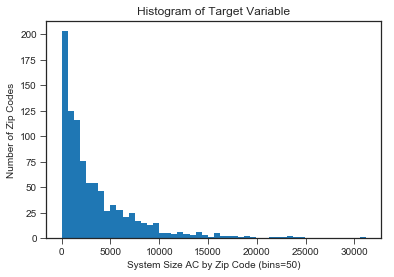

In [5]:
# plot histogram of target variable
# note: skewed-right, most zip codes have little System Size AC installed capacity, while there is a long-tail
# of few zip codes that have much System Size AC installed capacity

plt.hist(df['System Size AC'], bins=50);
plt.title('Histogram of Target Variable')
plt.xlabel('System Size AC by Zip Code (bins=50)')
plt.ylabel('Number of Zip Codes') 
plt.show()

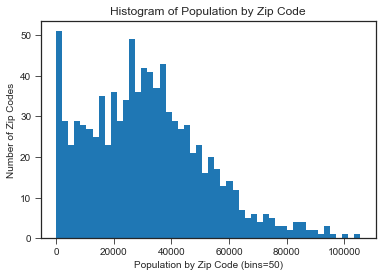

In [6]:
# plot histogram of Population by zip code

plt.hist(df['Population'], bins=50);
plt.title('Histogram of Population by Zip Code')
plt.xlabel('Population by Zip Code (bins=50)')
plt.ylabel('Number of Zip Codes') 
plt.show()

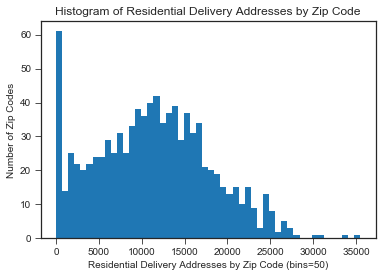

In [7]:
# plot histogram of number of residential delivery addresses by zip code
# note: shape is different from System Size AC histogram shape -> therefore, installed capacity
# must be dependent on other features than number of delivery addresses

plt.hist(df['Delivery Residential'], bins=50);
plt.title('Histogram of Residential Delivery Addresses by Zip Code')
plt.xlabel('Residential Delivery Addresses by Zip Code (bins=50)')
plt.ylabel('Number of Zip Codes') 
plt.show()

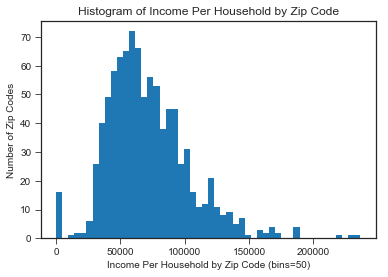

In [8]:
# plot histogram of Income Per Household by zip code

plt.hist(df['Income Per Household'], bins=50);
plt.title('Histogram of Income Per Household by Zip Code')
plt.xlabel('Income Per Household by Zip Code (bins=50)')
plt.ylabel('Number of Zip Codes') 
plt.show()

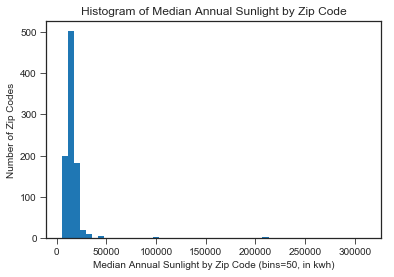

In [9]:
# plot histogram of Income Per Household by zip code

plt.hist(df['yearly_sunlight_kwh_median'], bins=50);
plt.title('Histogram of Median Annual Sunlight by Zip Code')
plt.xlabel('Median Annual Sunlight by Zip Code (bins=50, in kwh)')
plt.ylabel('Number of Zip Codes') 
plt.show()

In [10]:
# 2.7% of Zip Codes (i.e. 25 out of 928) have extremely high Median Annual Sunlight by Zip Code

df[df['yearly_sunlight_kwh_median'] < 30000].shape[0], df.shape[0]

(903, 928)

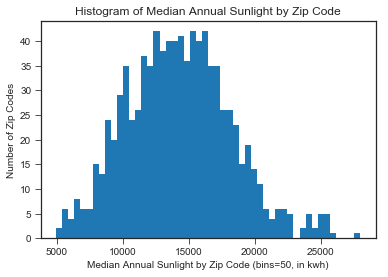

In [11]:
# plot histogram of Median Annual Sunlight by zip code with filter for < 30000

plt.hist(df[df['yearly_sunlight_kwh_median'] < 30000]['yearly_sunlight_kwh_median'], bins=50);
plt.title('Histogram of Median Annual Sunlight by Zip Code')
plt.xlabel('Median Annual Sunlight by Zip Code (bins=50, in kwh)')
plt.ylabel('Number of Zip Codes') 
plt.show()

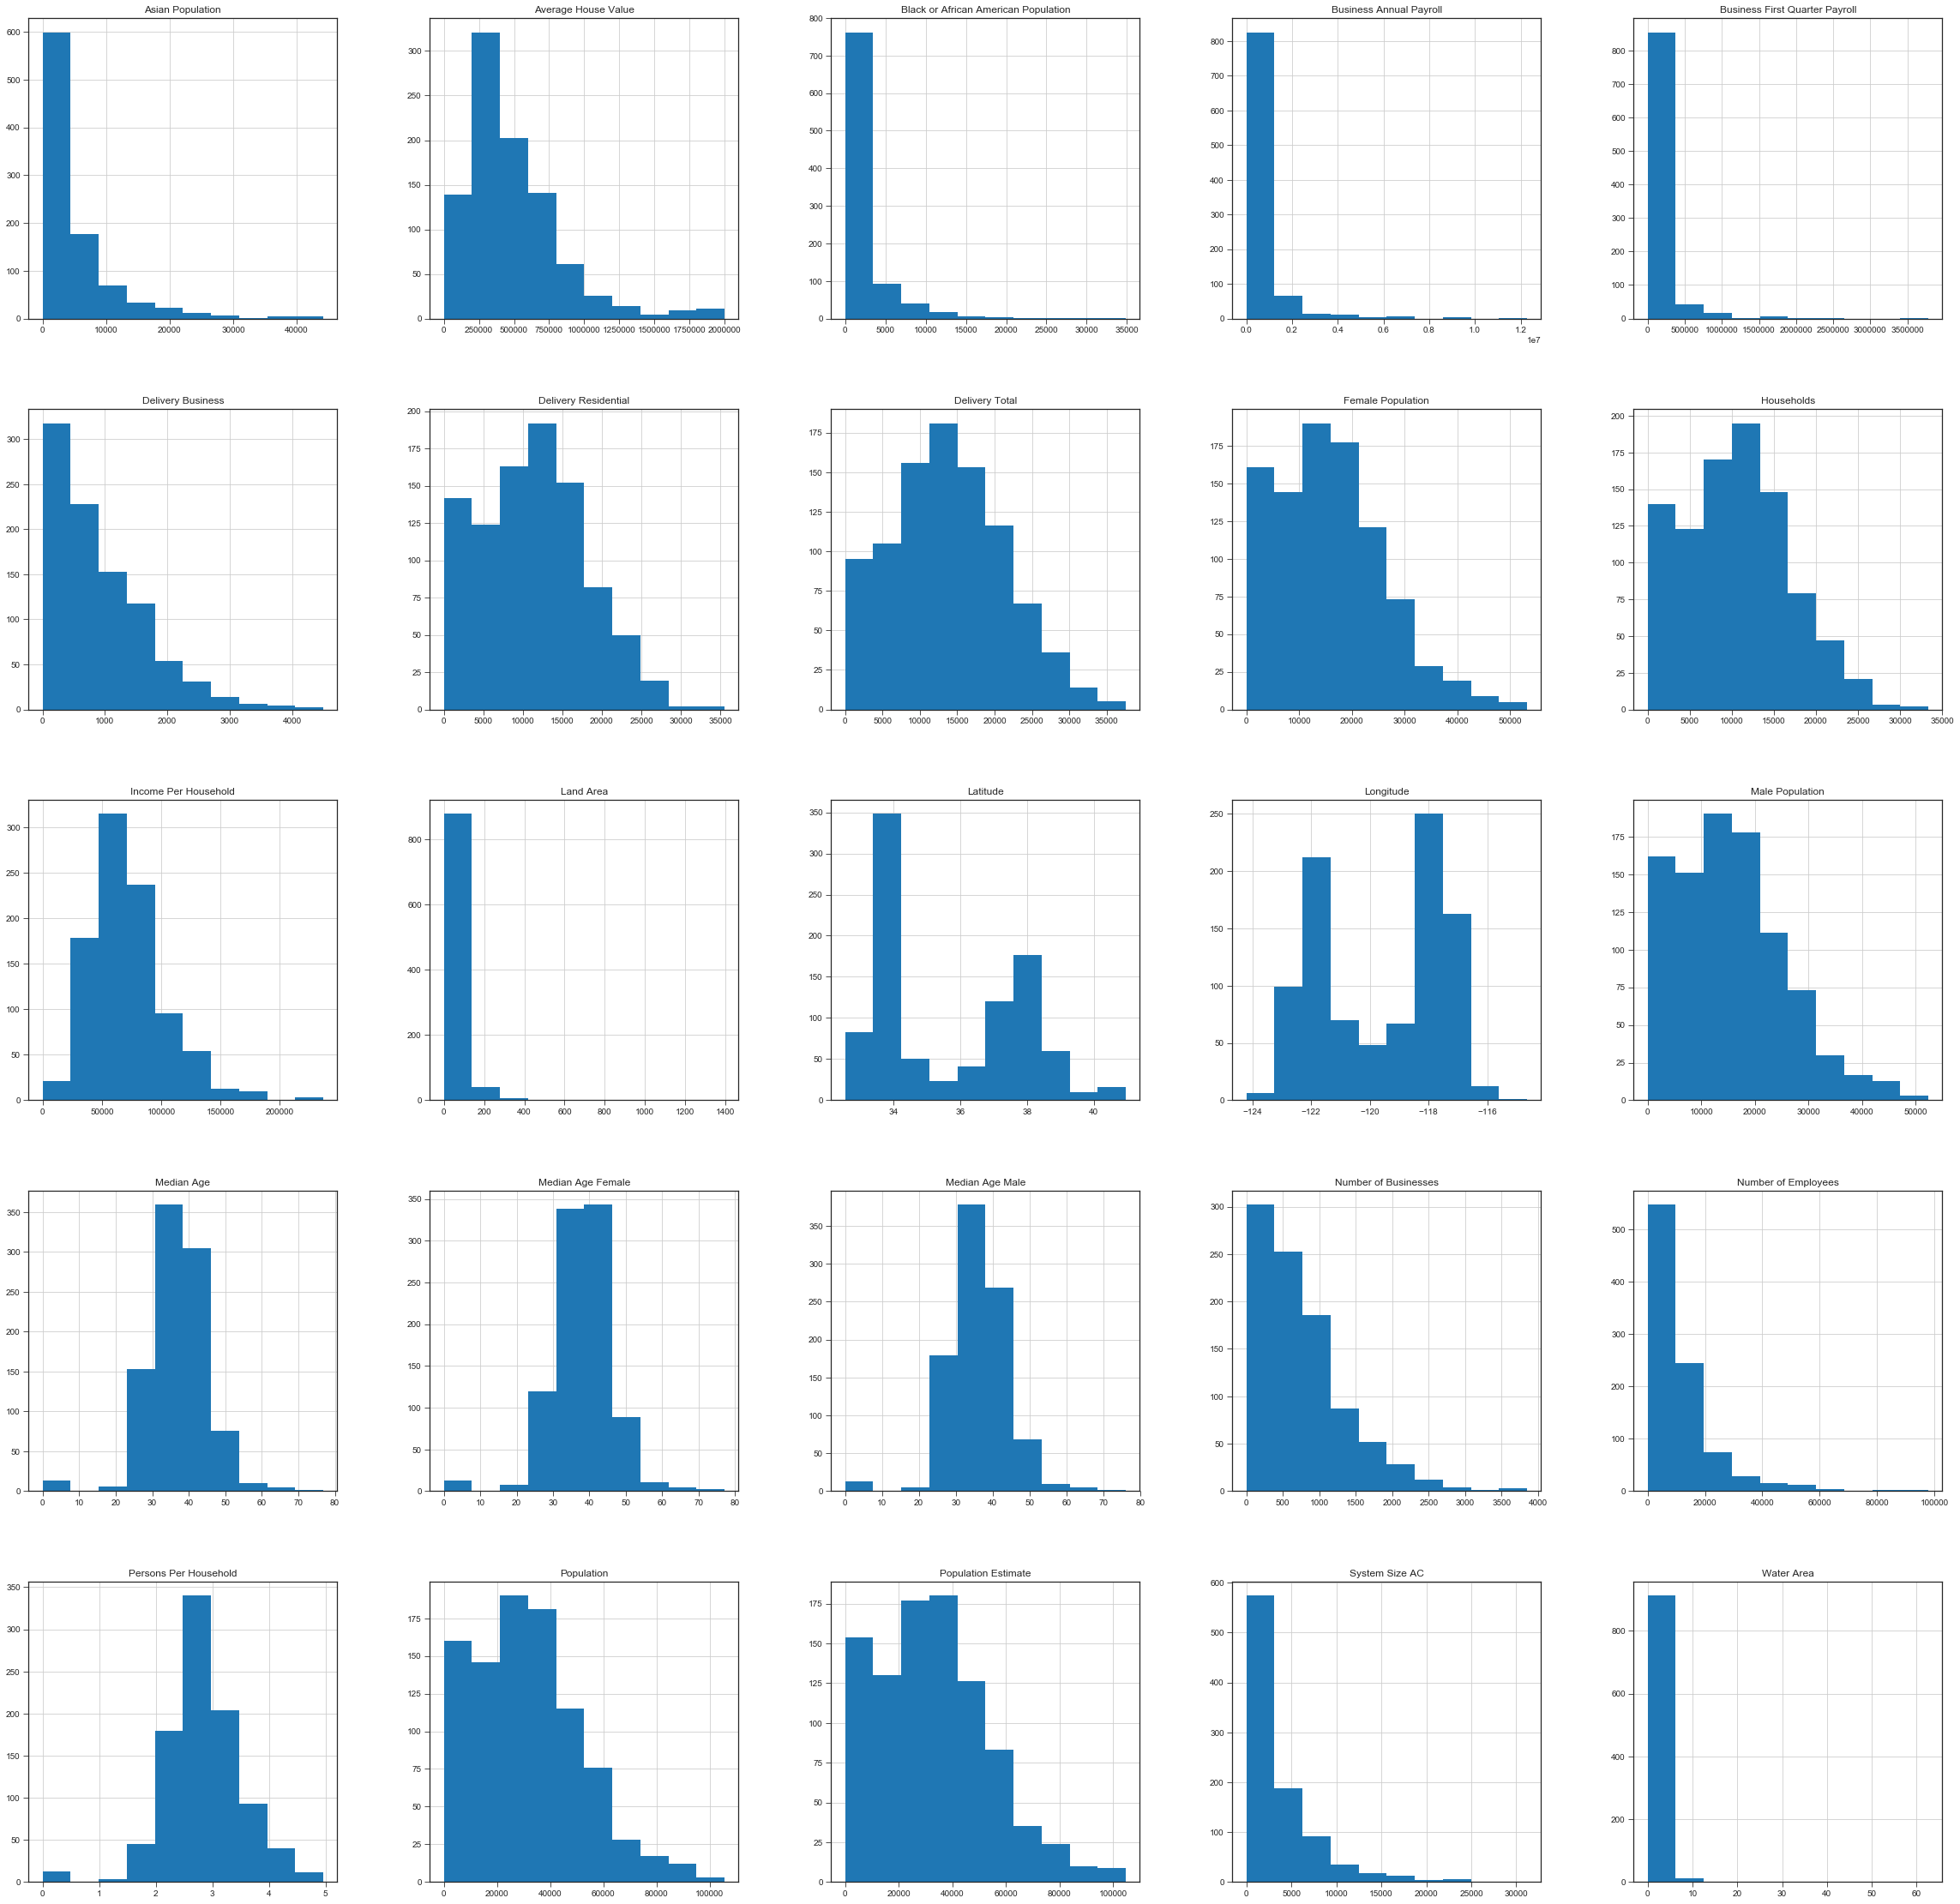

In [12]:
# histogram of features :25

df.iloc[:,:25].hist(figsize=(40,40));

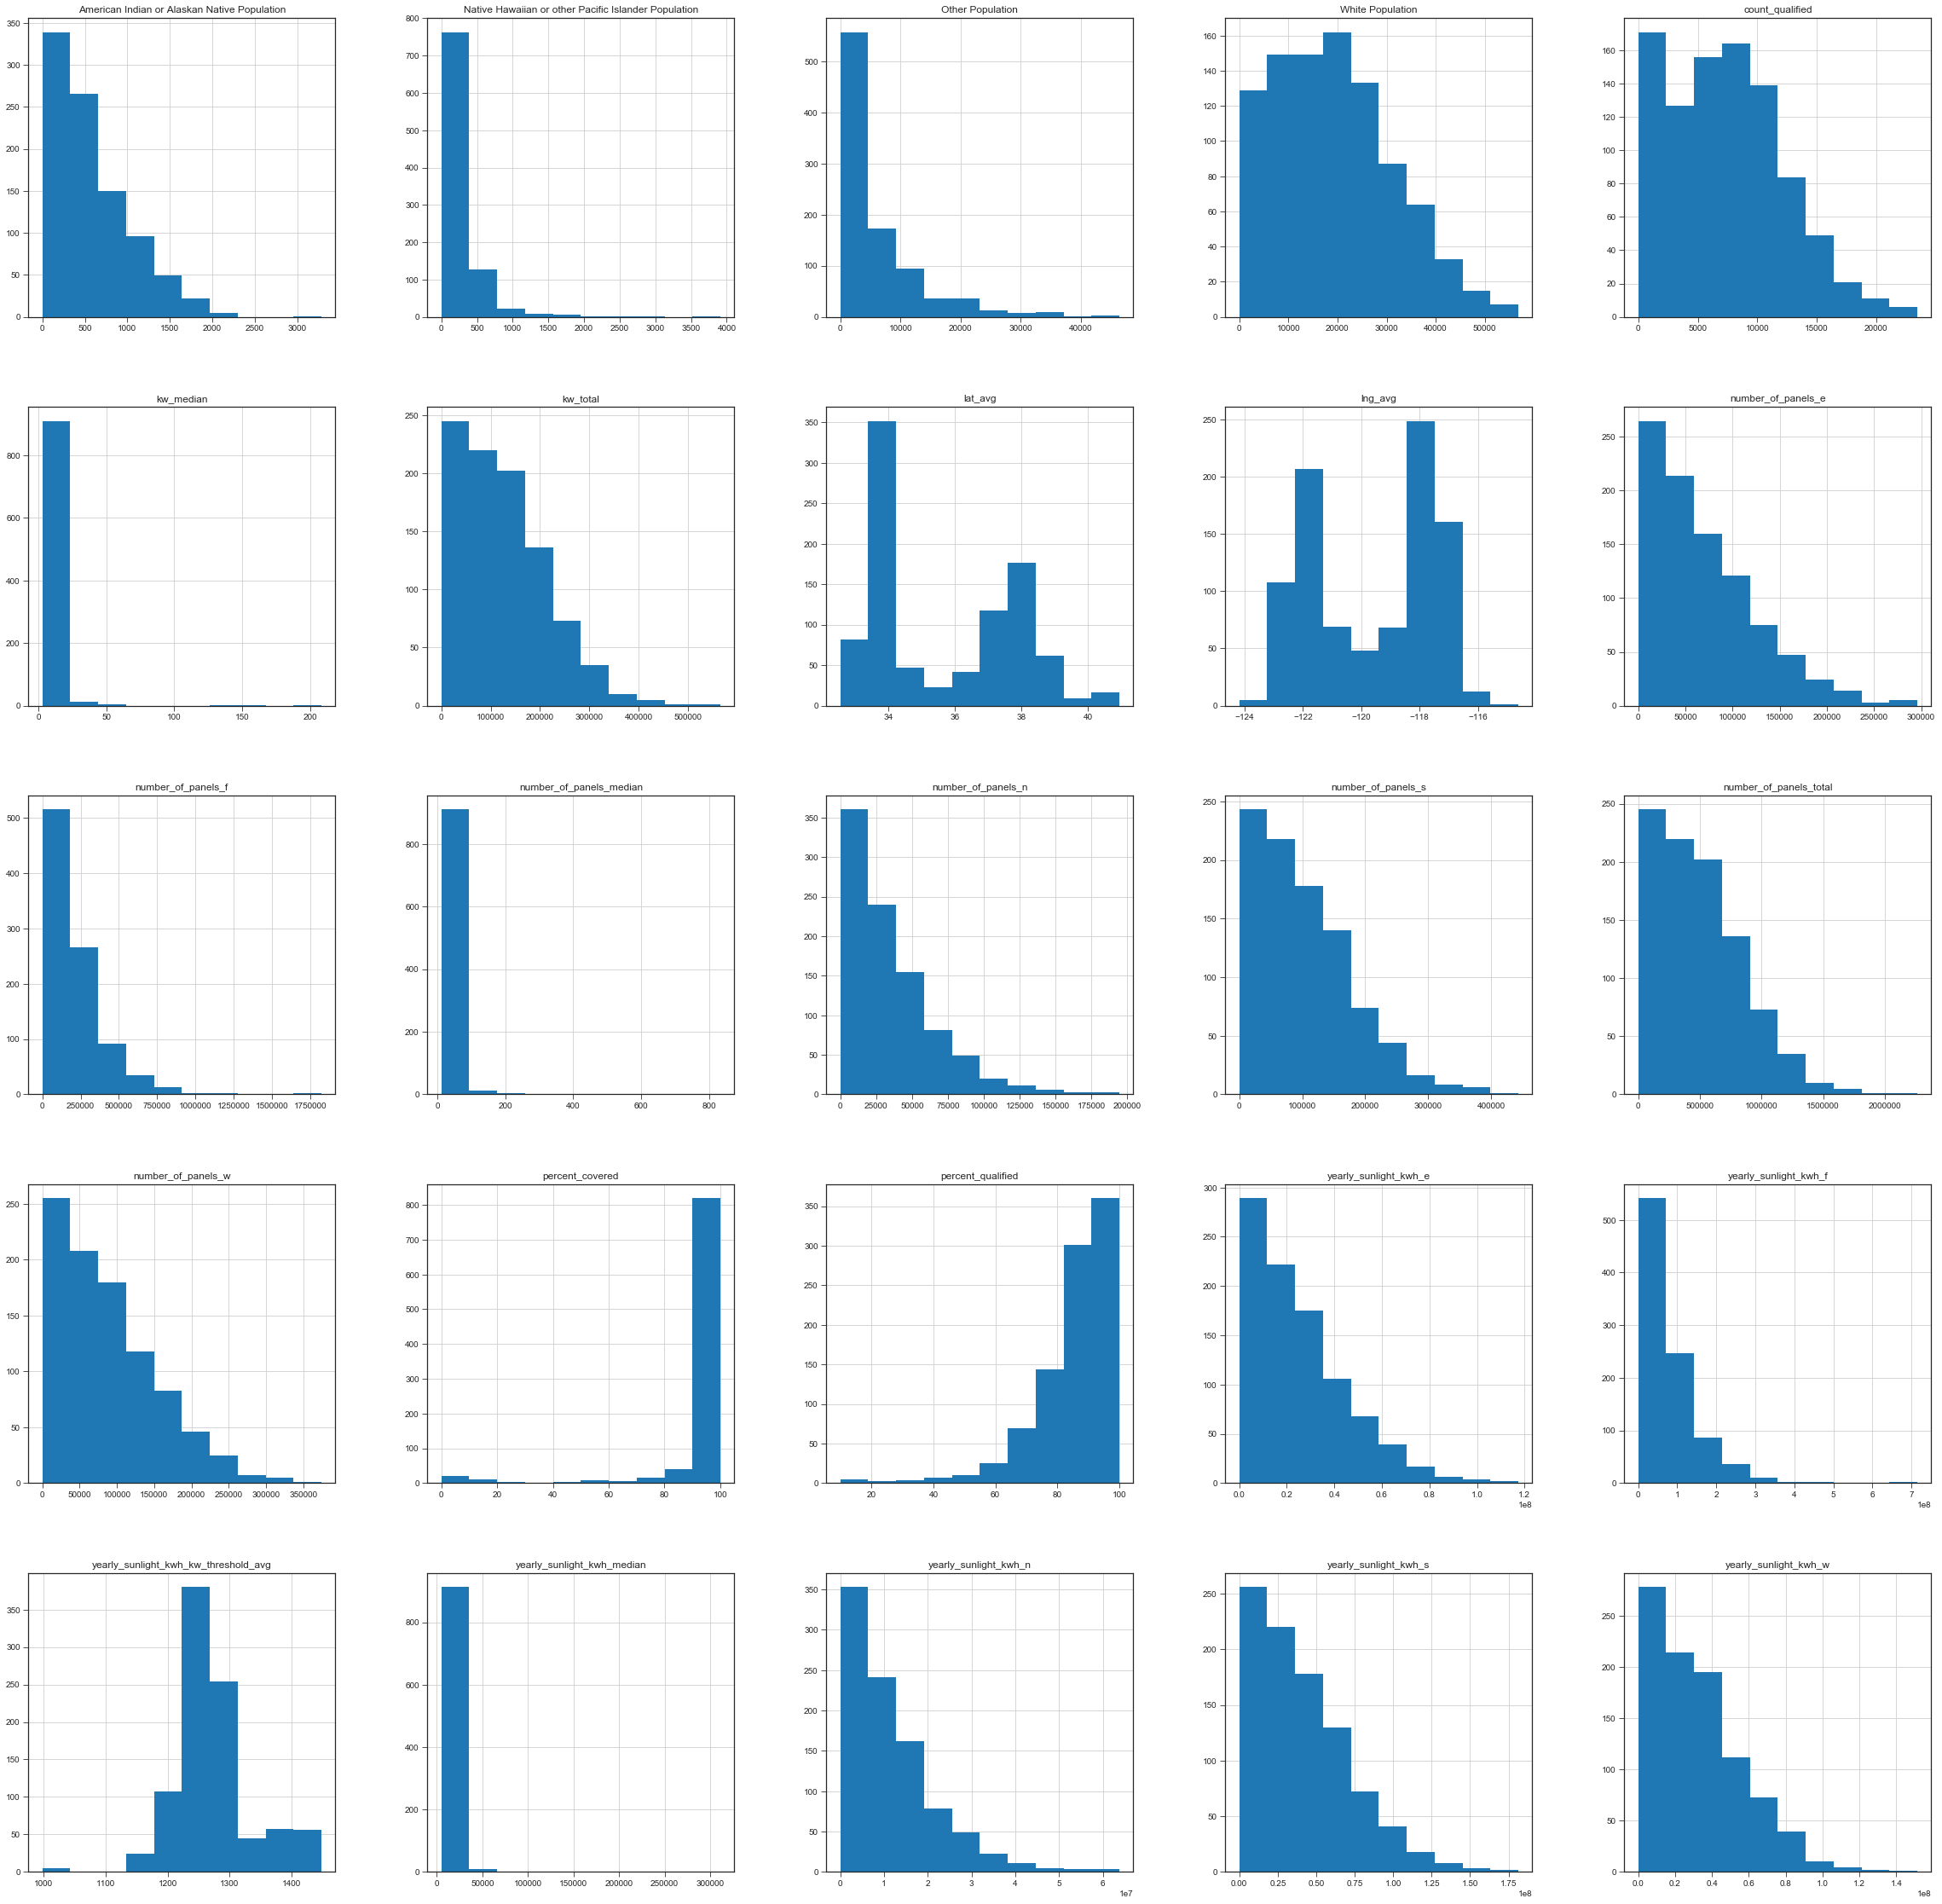

In [13]:
# histogram of features 25:50

df.iloc[:,25:50].hist(figsize=(40,40));

## Pairplots

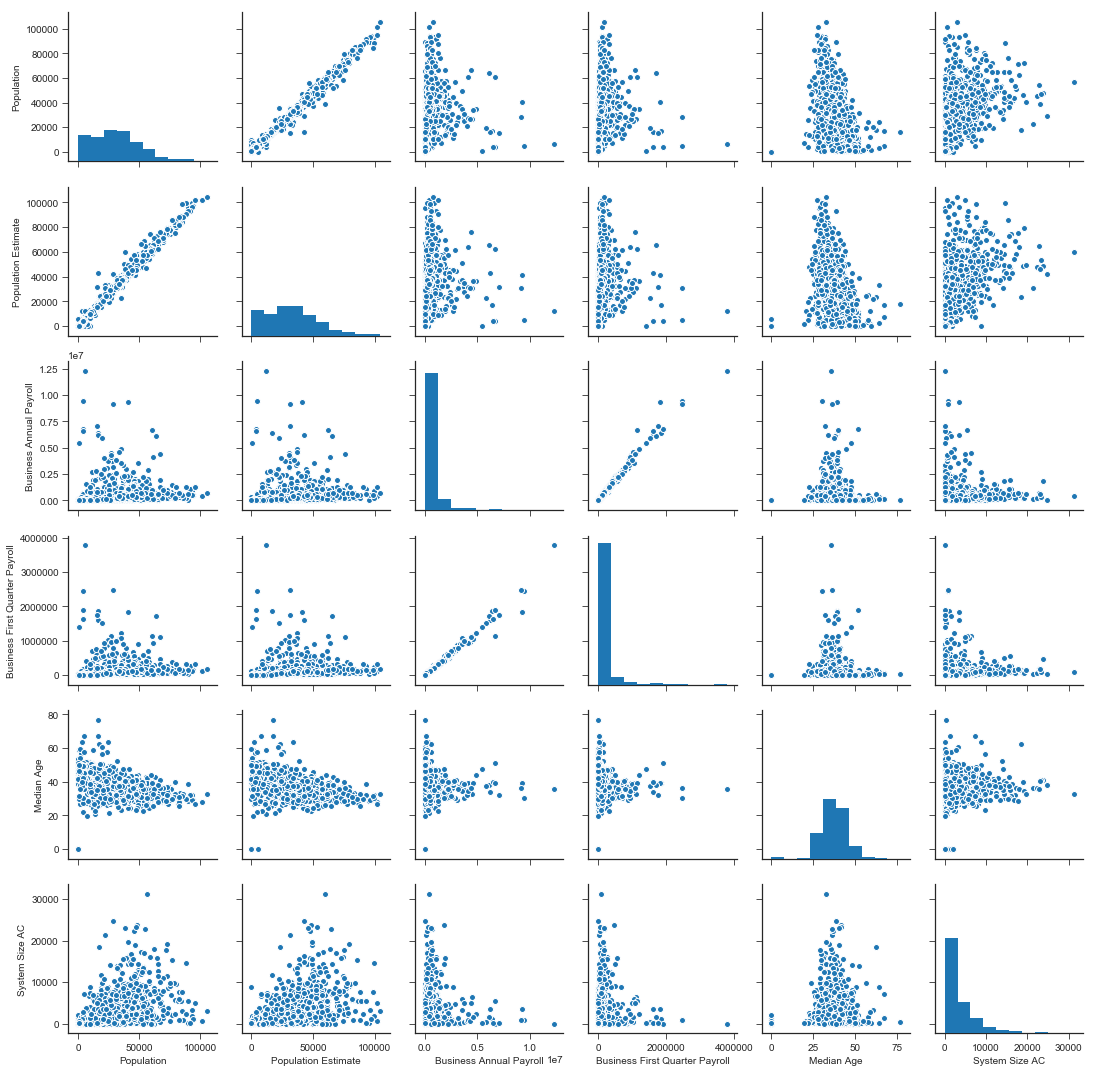

In [14]:
abc = list(df.columns[1:6])
abc.append('System Size AC')
sns.pairplot(df[abc]);

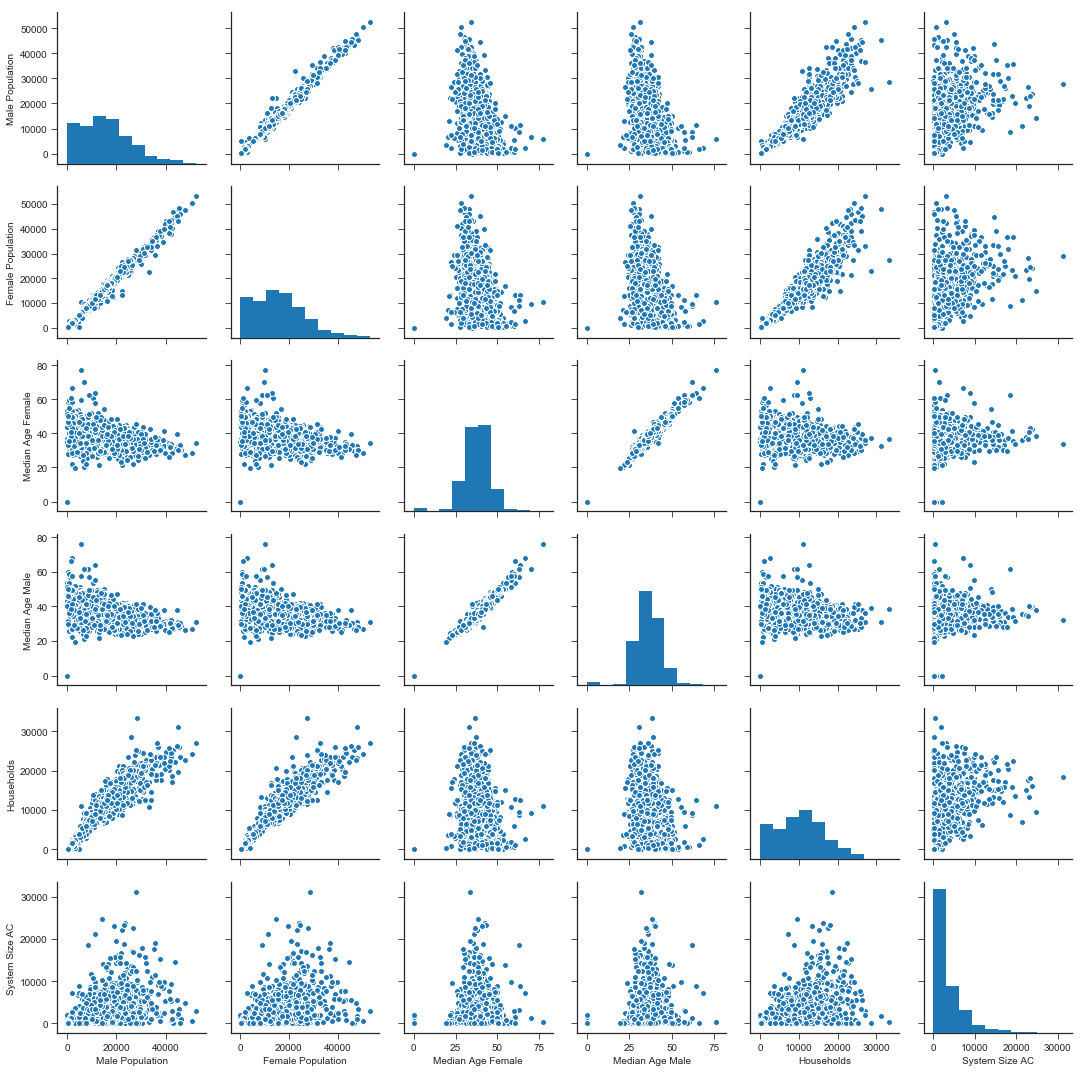

In [15]:
abc = list(df.columns[6:11])
abc.append('System Size AC')
sns.pairplot(df[abc]);

# Train-Test Split

In [16]:
## separate our features from our target

target = 'System Size AC'
features = list(df.columns)
features.remove(target)

y = df[target]
X = df.loc[:,features]

In [17]:
# split the data into a 70-30 train/test

X_tr, X_te, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=4444)

In [18]:
# scale data with standard scaler

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_tr)
X_test = standard_scaler.transform(X_te)

# Linear Regression Modeling

In [19]:
cv_results = {}

## 1-Feature Linear Regression

In [20]:
# first let us fit only on Delivery Residential (number of living units)

selected_columns_1 = ['Delivery Residential']
selected_columns_1_indices = [df.columns.get_loc(x) for x in selected_columns_1]

In [21]:
# cross-validate LinearRegression OLS on 1-variable

cv_results['lr_1'] = cross_validate(LinearRegression(), X_train[:,selected_columns_1_indices], y_train, \
                                    scoring='r2', cv=5, n_jobs=-1)

/Users/ryanrunchey/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Users/ryanrunchey/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Users/ryanrunchey/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falli

In [22]:
cv_results['lr_1']

{'fit_time': array([0.05182123, 0.05123591, 0.03962088, 0.03054309, 0.00150585]),
 'score_time': array([0.00147986, 0.00138211, 0.00177193, 0.00192785, 0.0004828 ]),
 'test_score': array([0.207467  , 0.14515947, 0.11335753, 0.16873763, 0.15527874]),
 'train_score': array([0.16319588, 0.17664423, 0.172856  , 0.17217157, 0.17555996])}

In [23]:
# print avg cv_results thus far

for k,v in cv_results.items():
    print(k)
    print()
    for key,value in v.items():
        print("{}: avg {}".format(key,round(value.mean(),3)))
    print()
    print()

lr_1

fit_time: avg 0.035
score_time: avg 0.001
test_score: avg 0.158
train_score: avg 0.172




In [24]:
# fit LinearRegression OLS on 1-variable

lr_1 = LinearRegression()
lr_1.fit(X_train[:,selected_columns_1_indices],y_train)

/Users/ryanrunchey/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
# formula for LinearRegression OLS on 1-variable

print("y = {} * x + {}".format(round(lr_1.coef_[0],3), round(lr_1.intercept_,3)))

y = 1631.837 * x + 3415.041


In [26]:
# columns and coefficients

pd.DataFrame(list(zip(selected_columns_1,lr_1.coef_)), columns=['Column', 'Coefficient'])

,Column,Coefficient
0,Delivery Residential,1631.83693


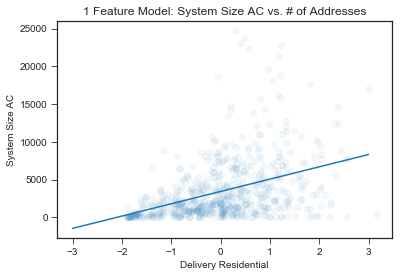

In [27]:
# scatter plot lr_1

plt.scatter(X_train[:,selected_columns_1_indices],y_train,alpha=.05)
vec1 = np.linspace(-3,3,3000)
plt.xlabel('Delivery Residential')
plt.ylabel('System Size AC')
plt.title('1 Feature Model: System Size AC vs. # of Addresses')
plt.plot(vec1, lr_1.coef_[0]*vec1 + lr_1.intercept_);

In [28]:
# get the predictions on the test set
test_set_pred_1 = lr_1.predict(X_test[:,selected_columns_1_indices])

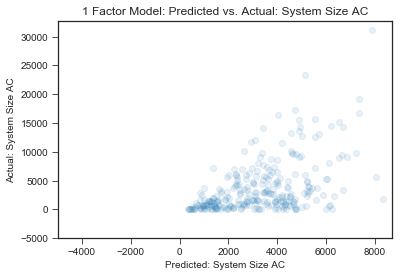

In [29]:
# plot predicted vs actual

plt.scatter(test_set_pred_1,y_test,alpha=.1)
plt.xlim(-5000)
plt.ylim(-5000)
plt.xlabel('Predicted: System Size AC')
plt.ylabel('Actual: System Size AC')
plt.title('1 Factor Model: Predicted vs. Actual');

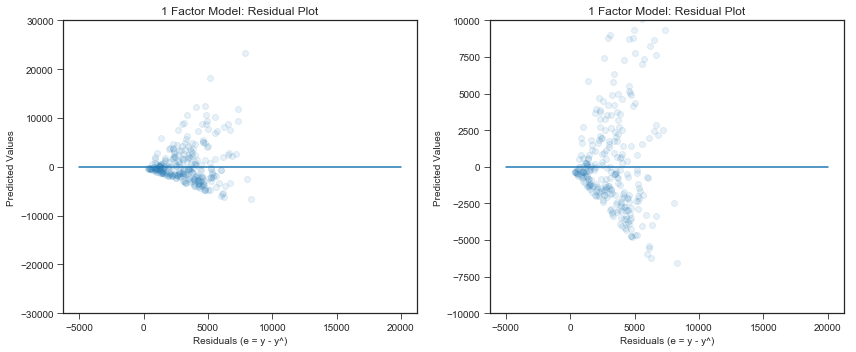

In [30]:
# residual plot(s) shown on two different ylim scales
# note: these residuals are Unbiased, but Heteroscadastic.
# The SD is small to the left of the plot and large to the right: the residuals are heteroscadastic.
# http://condor.depaul.edu/sjost/it223/documents/regress.htm

plt.subplots(1,2, figsize=(12,5))
plt.subplot(121)

plt.scatter(test_set_pred_1, y_test-test_set_pred_1,alpha=.1)
plt.title('1 Factor Model: Residual Plot')
plt.plot(np.linspace(-5000,20000,1000),np.linspace(0,0,1000))
plt.ylim(-30000,30000)
plt.xlabel('Residuals (e = y - y^)')
plt.ylabel('Predicted Values');

plt.subplot(122)
plt.scatter(test_set_pred_1, y_test-test_set_pred_1,alpha=.1)
plt.title('1 Factor Model: Residual Plot')
plt.plot(np.linspace(-5000,20000,1000), np.linspace(0,0,1000))
plt.ylim(-10000,10000)
plt.xlabel('Residuals (e = y - y^)')
plt.ylabel('Predicted Values');

plt.tight_layout()

In [31]:
# Final R^2 Test Score
r2_manual(y_test, test_set_pred_1)

0.22707065749404576

In [149]:
# Final RMSE Test Score
rmse_manual(y_test, test_set_pred_1)

3885.211825057667

## 4-Feature Linear Regression

In [32]:
selected_columns_2 = ['Delivery Residential', 'Land Area', 'Average House Value', 'yearly_sunlight_kwh_median']
selected_columns_2_indices = [df.columns.get_loc(x) for x in selected_columns_2]

In [33]:
# cross-validate LinearRegression OLS on 4-variable

cv_results['lr_2'] = cross_validate(LinearRegression(), X_train[:,selected_columns_2_indices], y_train, \
                                    scoring='r2', cv=5, n_jobs=-1)

In [34]:
cv_results['lr_2']

{'fit_time': array([0.03251195, 0.03025413, 0.00955009, 0.01168203, 0.00163627]),
 'score_time': array([0.00201225, 0.00131512, 0.00886774, 0.00141382, 0.00056982]),
 'test_score': array([0.30015418, 0.17424718, 0.27631635, 0.28359746, 0.14138232]),
 'train_score': array([0.24707803, 0.27262417, 0.24660419, 0.24839965, 0.28244241])}

In [35]:
# print avg cv_results thus far

for k,v in cv_results.items():
    print(k)
    print()
    for key,value in v.items():
        print("{}: avg {}".format(key,round(value.mean(),3)))
    print()
    print()

lr_1

fit_time: avg 0.035
score_time: avg 0.001
test_score: avg 0.158
train_score: avg 0.172


lr_2

fit_time: avg 0.017
score_time: avg 0.003
test_score: avg 0.235
train_score: avg 0.259




In [36]:
# fit LinearRegression OLS on 4-variables

lr_2 = LinearRegression()
lr_2.fit(X_train[:,selected_columns_2_indices],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [37]:
# formula for LinearRegression OLS on 4-variable

print("y = {} * x1 + {} * x2 + {} * x3 + {} * x4 + {}" \
      .format(round(lr_2.coef_[0],3), round(lr_2.coef_[1],3), round(lr_2.coef_[2],3),\
              round(lr_2.coef_[3],3), round(lr_2.intercept_,3)))

y = 525.51 * x1 + 22.839 * x2 + 95.817 * x3 + 1615.1 * x4 + 3415.041


In [38]:
# columns and coefficients

pd.DataFrame(list(zip(selected_columns_2,lr_2.coef_)), columns=['Column', 'Coefficient'])

,Column,Coefficient
0,Delivery Residential,525.509667
1,Land Area,22.839383
2,Average House Value,95.817489
3,yearly_sunlight_kwh_median,1615.100361


In [39]:
# get the predictions on the test set
test_set_pred_2 = lr_2.predict(X_test[:,selected_columns_2_indices])

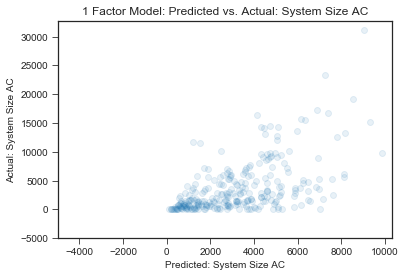

In [40]:
# plot predicted vs actual

plt.scatter(test_set_pred_2,y_test,alpha=.1)
plt.xlim(-5000)
plt.ylim(-5000)
plt.xlabel('Predicted: System Size AC')
plt.ylabel('Actual: System Size AC')
plt.title('1 Factor Model: Predicted vs. Actual');

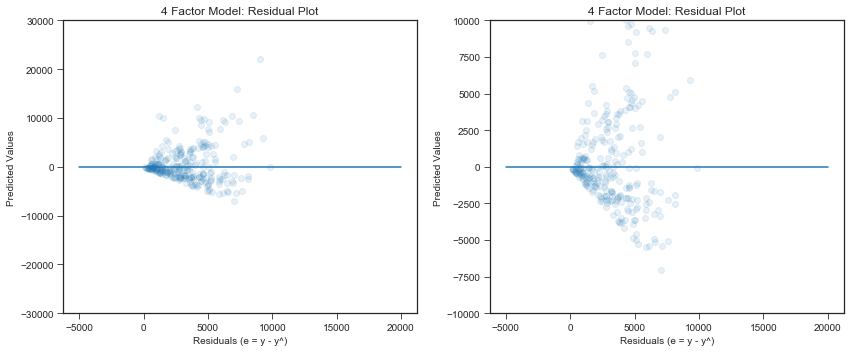

In [41]:
# residual plot(s) shown on two different ylim scales
# note: these residuals are Unbiased, but Heteroscadastic.
# The SD is small to the left of the plot and large to the right: the residuals are heteroscadastic.
# http://condor.depaul.edu/sjost/it223/documents/regress.htm

plt.subplots(1,2, figsize=(12,5))
plt.subplot(121)

plt.scatter(test_set_pred_2, y_test-test_set_pred_2,alpha=.1)
plt.title('4 Factor Model: Residual Plot')
plt.plot(np.linspace(-5000,20000,1000),np.linspace(0,0,1000))
plt.ylim(-30000,30000)
plt.xlabel('Residuals (e = y - y^)')
plt.ylabel('Predicted Values');

plt.subplot(122)
plt.scatter(test_set_pred_2, y_test-test_set_pred_2,alpha=.1)
plt.title('4 Factor Model: Residual Plot')
plt.plot(np.linspace(-5000,20000,1000),np.linspace(0,0,1000))
plt.ylim(-10000,10000)
plt.xlabel('Residuals (e = y - y^)')
plt.ylabel('Predicted Values');

plt.tight_layout()

In [42]:
# Final R^2 Test Score
r2_manual(y_test, test_set_pred_2)

0.2995147749106669

In [150]:
# Final RMSE Test Score
rmse_manual(y_test, test_set_pred_2)

3698.65900982538

### Heatmap Pairplot

In [43]:
# correlation matrix

df[selected_columns_2].corr()

,Delivery Residential,Land Area,Average House Value,yearly_sunlight_kwh_median
Delivery Residential,1.000000,0.014763,-0.045280,-0.139455
Land Area,0.014763,1.000000,-0.150116,0.012964
Average House Value,-0.045280,-0.150116,1.000000,-0.099857
yearly_sunlight_kwh_median,-0.139455,0.012964,-0.099857,1.000000


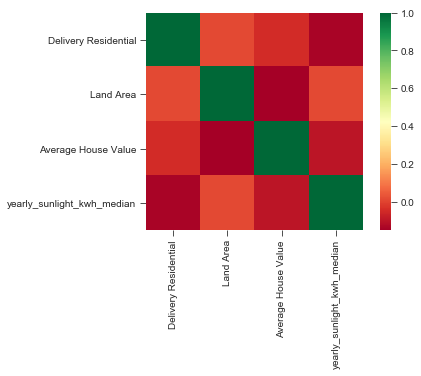

In [44]:
sns.heatmap(df[selected_columns_2].corr(), square=True, cmap='RdYlGn');

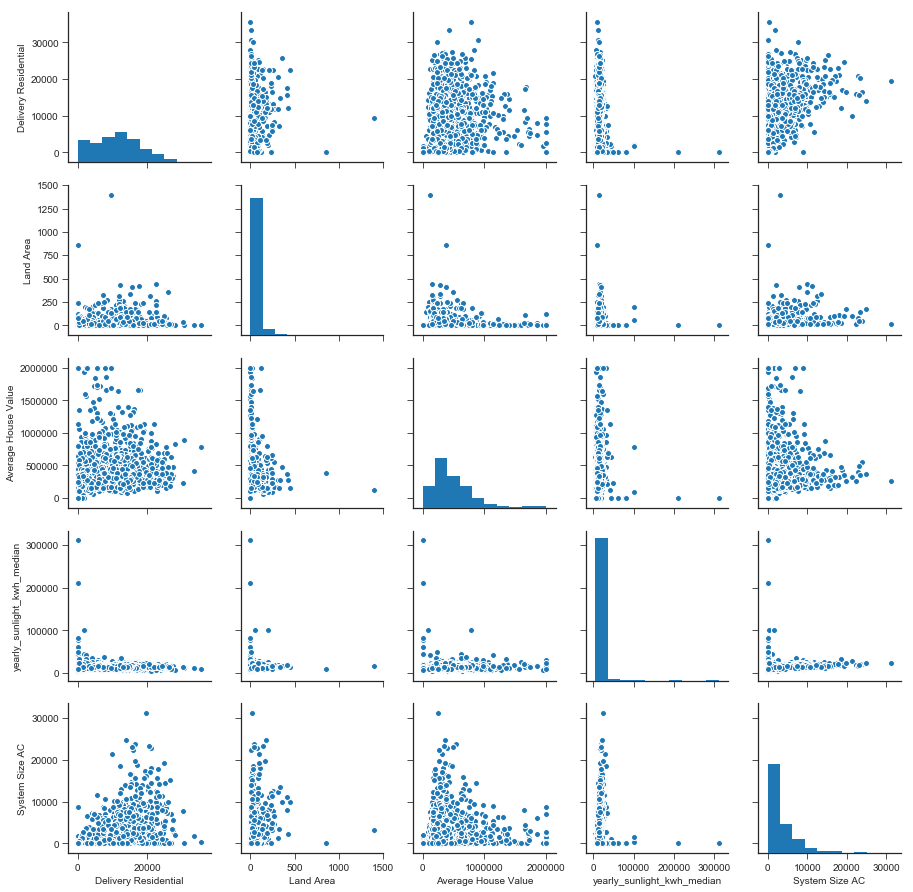

In [45]:
col_pairplot_2 = copy.deepcopy(selected_columns_2)
col_pairplot_2.append('System Size AC')
sns_pairplot = sns.pairplot(df[col_pairplot_2]);

## All-Feature Linear Regression

In [46]:
# cross-validate LinearRegression OLS on all-variables

cv_results['lr_3'] = cross_validate(LinearRegression(), X_train, y_train, \
                                    scoring='r2', cv=5, n_jobs=-1)

In [47]:
cv_results['lr_3']

{'fit_time': array([0.03759384, 0.01413321, 0.01159096, 0.00715423, 0.00261998]),
 'score_time': array([0.00323915, 0.00451589, 0.00321317, 0.00110793, 0.00045109]),
 'test_score': array([0.61964416, 0.57041651, 0.51606946, 0.5316777 , 0.52836306]),
 'train_score': array([0.63876708, 0.64178253, 0.64847676, 0.65934901, 0.65118199])}

In [48]:
# print avg cv_results thus far

for k,v in cv_results.items():
    print(k)
    print()
    for key,value in v.items():
        print("{}: avg {}".format(key,round(value.mean(),3)))
    print()
    print()

lr_1

fit_time: avg 0.035
score_time: avg 0.001
test_score: avg 0.158
train_score: avg 0.172


lr_2

fit_time: avg 0.017
score_time: avg 0.003
test_score: avg 0.235
train_score: avg 0.259


lr_3

fit_time: avg 0.015
score_time: avg 0.003
test_score: avg 0.553
train_score: avg 0.648




In [49]:
lr_3 = LinearRegression()
lr_3.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [50]:
# columns and coefficients

pd.DataFrame(list(zip(X.columns,lr_3.coef_)), columns=['Column', 'Coefficient'])

,Column,Coefficient
0,Population,-6.882698e+12
1,Population Estimate,9.870293e+03
2,Business Annual Payroll,-4.700882e+02
3,Business First Quarter Payroll,2.713220e+02
4,Median Age,-4.819619e+01
5,Male Population,3.436948e+12
6,Female Population,3.461551e+12
7,Median Age Female,-5.218071e+02
8,Median Age Male,7.190616e+02
9,Households,1.454758e+03


In [51]:
# get the predictions on the test set
test_set_pred_3 = lr_3.predict(X_test)

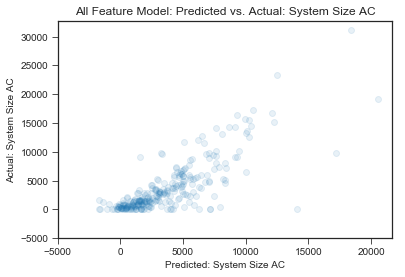

In [52]:
# plot predicted vs actual

plt.scatter(test_set_pred_3,y_test,alpha=.1)
plt.xlim(-5000)
plt.ylim(-5000)
plt.xlabel('Predicted: System Size AC')
plt.ylabel('Actual: System Size AC')
plt.title('All Feature Model: Predicted vs. Actual');

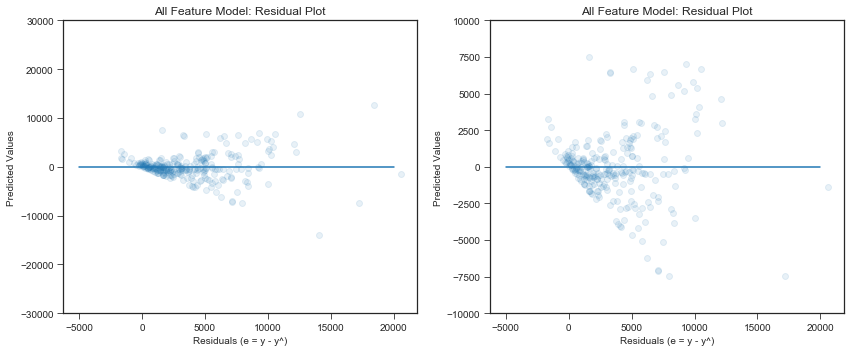

In [53]:
# residual plot(s) shown on two different ylim scales
# note: these residuals are Unbiased, but Heteroscadastic.
# The SD is small to the left of the plot and large to the right: the residuals are heteroscadastic.
# http://condor.depaul.edu/sjost/it223/documents/regress.htm

plt.subplots(1,2, figsize=(12,5))
plt.subplot(121)

plt.scatter(test_set_pred_3,y_test-test_set_pred_3,alpha=.1)
plt.title('All Feature Model: Residual Plot')
plt.plot(np.linspace(-5000,20000,1000),np.linspace(0,0,1000))
plt.ylim(-30000,30000)
plt.xlabel('Residuals (e = y - y^)')
plt.ylabel('Predicted Values');

plt.subplot(122)
plt.scatter(test_set_pred_3,y_test-test_set_pred_3,alpha=.1)
plt.title('All Feature Model: Residual Plot')
plt.plot(np.linspace(-5000,20000,1000),np.linspace(0,0,1000))
plt.ylim(-10000,10000)
plt.xlabel('Residuals (e = y - y^)')
plt.ylabel('Predicted Values');

plt.tight_layout()

In [54]:
# Final R^2 Test Score
r2_manual(y_test, test_set_pred_3)

0.6386870244548084

In [152]:
# Final RMSE Test Score
rmse_manual(y_test, test_set_pred_3)

2656.3578703450366

## All-Feature Lasso Regression

In [55]:
# cross-validate LinearRegression OLS on all-variables

# use a full grid over all parameters
param_grid_lasso = {"alpha": np.logspace(1,12,12,base=2),
             "random_state": [4444],
             "tol": [0.1]}

# run grid search
grid_search_lasso = GridSearchCV(Lasso(), param_grid=param_grid_lasso, scoring='r2', cv=5, verbose=1, n_jobs=-1,)

grid_search_lasso.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01, 3.200e+01, 6.400e+01,
       1.280e+02, 2.560e+02, 5.120e+02, 1.024e+03, 2.048e+03, 4.096e+03]), 'random_state': [4444], 'tol': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [56]:
# view cv_results
pd.DataFrame(grid_search_lasso.cv_results_) 

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,param_random_state,param_tol,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.244806,0.001533,0.562536,0.638116,2,4444,0.1,"{'alpha': 2.0, 'random_state': 4444, 'tol': 0.1}",1,0.646824,...,0.527312,0.641434,0.522820,0.651346,0.509544,0.642664,0.114821,0.000541,0.054038,0.009342
1,0.014869,0.001429,0.560547,0.632570,4,4444,0.1,"{'alpha': 4.0, 'random_state': 4444, 'tol': 0.1}",2,0.642878,...,0.535430,0.636778,0.519732,0.647555,0.507326,0.640281,0.003170,0.001267,0.051443,0.011523
2,0.005956,0.000553,0.558192,0.625164,8,4444,0.1,"{'alpha': 8.0, 'random_state': 4444, 'tol': 0.1}",3,0.643082,...,0.553198,0.626399,0.520325,0.641462,0.494828,0.632152,0.000841,0.000032,0.051194,0.011106
3,0.003292,0.000567,0.539015,0.603870,16,4444,0.1,"{'alpha': 16.0, 'random_state': 4444, 'tol': 0.1}",4,0.637224,...,0.558157,0.603564,0.526314,0.623307,0.449242,0.611098,0.000927,0.000029,0.060730,0.012486
4,0.002735,0.000531,0.525390,0.584303,32,4444,0.1,"{'alpha': 32.0, 'random_state': 4444, 'tol': 0.1}",5,0.611522,...,0.557355,0.582410,0.525009,0.596507,0.417211,0.594707,0.002127,0.000147,0.063548,0.010758
5,0.001821,0.000504,0.520969,0.573636,64,4444,0.1,"{'alpha': 64.0, 'random_state': 4444, 'tol': 0.1}",7,0.597894,...,0.561877,0.570260,0.526027,0.581304,0.413379,0.587492,0.000353,0.000101,0.062279,0.010236
6,0.001858,0.000425,0.521399,0.560729,128,4444,0.1,"{'alpha': 128.0, 'random_state': 4444, 'tol': ...",6,0.586781,...,0.574431,0.558514,0.534906,0.564772,0.437075,0.576197,0.000298,0.000096,0.057756,0.009921
7,0.001089,0.000279,0.510360,0.534677,256,4444,0.1,"{'alpha': 256.0, 'random_state': 4444, 'tol': ...",8,0.565223,...,0.562525,0.531178,0.517910,0.533097,0.446601,0.551071,0.000180,0.000021,0.049949,0.009776
8,0.001078,0.000266,0.457446,0.468386,512,4444,0.1,"{'alpha': 512.0, 'random_state': 4444, 'tol': ...",9,0.512097,...,0.530157,0.465606,0.459481,0.463711,0.414828,0.480913,0.000435,0.000019,0.059489,0.007683
9,0.003136,0.000497,0.393249,0.398099,1024,4444,0.1,"{'alpha': 1024.0, 'random_state': 4444, 'tol':...",10,0.433703,...,0.458018,0.387251,0.386535,0.390875,0.362217,0.409166,0.004218,0.000430,0.047823,0.012722


In [57]:
# view the best_estimator from GridSearchCV
grid_search_lasso.best_estimator_

Lasso(alpha=2.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=4444,
   selection='cyclic', tol=0.1, warm_start=False)

In [58]:
# cross-validate LinearRegression Lasso on all-variables

cv_results['lr_4'] = cross_validate(grid_search_lasso.best_estimator_, X_train, y_train, \
                                    scoring='r2', cv=5, n_jobs=-1)

In [59]:
cv_results['lr_4']

{'fit_time': array([0.04273009, 0.04529572, 0.03792477, 0.03135896, 0.014678  ]),
 'score_time': array([0.00148582, 0.00157905, 0.00163507, 0.00191426, 0.00068808]),
 'test_score': array([0.64682352, 0.60577113, 0.52731172, 0.52282031, 0.50954444]),
 'train_score': array([0.62568547, 0.62945077, 0.64143426, 0.65134623, 0.64266441])}

In [60]:
# print avg cv_results thus far

for k,v in cv_results.items():
    print(k)
    print()
    for key,value in v.items():
        print("{}: avg {}".format(key,round(value.mean(),3)))
    print()
    print()

lr_1

fit_time: avg 0.035
score_time: avg 0.001
test_score: avg 0.158
train_score: avg 0.172


lr_2

fit_time: avg 0.017
score_time: avg 0.003
test_score: avg 0.235
train_score: avg 0.259


lr_3

fit_time: avg 0.015
score_time: avg 0.003
test_score: avg 0.553
train_score: avg 0.648


lr_4

fit_time: avg 0.034
score_time: avg 0.001
test_score: avg 0.562
train_score: avg 0.638




In [61]:
lr_4 = grid_search_lasso.best_estimator_
lr_4.fit(X_train,y_train)

Lasso(alpha=2.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=4444,
   selection='cyclic', tol=0.1, warm_start=False)

In [62]:
# columns and coefficients

pd.DataFrame(list(zip(X.columns,lr_4.coef_)), columns=['Column', 'Coefficient'])

,Column,Coefficient
0,Population,1942.624756
1,Population Estimate,6769.663573
2,Business Annual Payroll,-173.523696
3,Business First Quarter Payroll,0.000000
4,Median Age,0.000000
5,Male Population,-824.910247
6,Female Population,-5212.654595
7,Median Age Female,-489.412938
8,Median Age Male,674.917068
9,Households,-977.523690


In [63]:
# get the predictions on the test set
test_set_pred_4 = lr_4.predict(X_test)

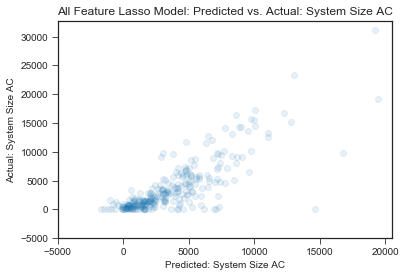

In [64]:
# plot predicted vs actual

plt.scatter(test_set_pred_4,y_test,alpha=.1)
plt.xlim(-5000)
plt.ylim(-5000)
plt.xlabel('Predicted: System Size AC')
plt.ylabel('Actual: System Size AC')
plt.title('All Feature Lasso Model: Predicted vs. Actual');

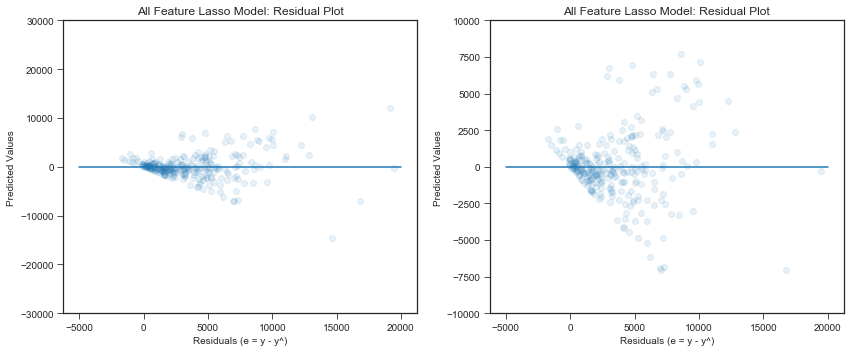

In [65]:
# residual plot(s) shown on two different ylim scales
# note: these residuals are Unbiased, but Heteroscadastic.
# The SD is small to the left of the plot and large to the right: the residuals are heteroscadastic.
# http://condor.depaul.edu/sjost/it223/documents/regress.htm

plt.subplots(1,2, figsize=(12,5))
plt.subplot(121)

plt.scatter(test_set_pred_4,y_test-test_set_pred_4,alpha=.1)
plt.title('All Feature Lasso Model: Residual Plot')
plt.plot(np.linspace(-5000,20000,1000),np.linspace(0,0,1000))
plt.ylim(-30000,30000)
plt.xlabel('Residuals (e = y - y^)')
plt.ylabel('Predicted Values');

plt.subplot(122)
plt.scatter(test_set_pred_4,y_test-test_set_pred_4,alpha=.1)
plt.title('All Feature Lasso Model: Residual Plot')
plt.plot(np.linspace(-5000,20000,1000),np.linspace(0,0,1000))
plt.ylim(-10000,10000)
plt.xlabel('Residuals (e = y - y^)')
plt.ylabel('Predicted Values');

plt.tight_layout()

In [66]:
# Final R^2 Test Score
r2_manual(y_test, test_set_pred_4)

0.6501925280967054

In [151]:
# Final RMSE Test Score
rmse_manual(y_test, test_set_pred_4)

2613.7217116550264

## All-Feature Ridge Regression

In [67]:
# cross-validate LinearRegression OLS on all-variables

# use a full grid over all parameters
param_grid_ridge = {"alpha": np.logspace(1,12,12,base=2),
             "random_state": [4444],
             "tol": [0.001,0.01,0.1]}

# run grid search
grid_search_ridge = GridSearchCV(Ridge(), param_grid=param_grid_ridge, scoring='r2', cv=5, verbose=1, n_jobs=-1)

grid_search_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01, 3.200e+01, 6.400e+01,
       1.280e+02, 2.560e+02, 5.120e+02, 1.024e+03, 2.048e+03, 4.096e+03]), 'random_state': [4444], 'tol': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [68]:
# view cv_results
pd.DataFrame(grid_search_ridge.cv_results_) 

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,param_random_state,param_tol,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.007666,0.001666,0.563755,0.633880,2,4444,0.001,"{'alpha': 2.0, 'random_state': 4444, 'tol': 0....",1,0.643950,...,0.539581,0.636079,0.532660,0.647001,0.505708,0.641436,0.002170,0.000746,0.049825,0.009988
1,0.002669,0.001060,0.563755,0.633880,2,4444,0.01,"{'alpha': 2.0, 'random_state': 4444, 'tol': 0.01}",1,0.643950,...,0.539581,0.636079,0.532660,0.647001,0.505708,0.641436,0.000283,0.000912,0.049825,0.009988
2,0.002457,0.000502,0.563755,0.633880,2,4444,0.1,"{'alpha': 2.0, 'random_state': 4444, 'tol': 0.1}",1,0.643950,...,0.539581,0.636079,0.532660,0.647001,0.505708,0.641436,0.001069,0.000032,0.049825,0.009988
3,0.003018,0.000569,0.561925,0.628514,4,4444,0.001,"{'alpha': 4.0, 'random_state': 4444, 'tol': 0....",4,0.643452,...,0.548985,0.629910,0.533197,0.641543,0.496311,0.636803,0.002029,0.000106,0.050137,0.010046
4,0.002235,0.001041,0.561925,0.628514,4,4444,0.01,"{'alpha': 4.0, 'random_state': 4444, 'tol': 0.01}",4,0.643452,...,0.548985,0.629910,0.533197,0.641543,0.496311,0.636803,0.000228,0.000993,0.050137,0.010046
5,0.002273,0.000610,0.561925,0.628514,4,4444,0.1,"{'alpha': 4.0, 'random_state': 4444, 'tol': 0.1}",4,0.643452,...,0.548985,0.629910,0.533197,0.641543,0.496311,0.636803,0.000554,0.000280,0.050137,0.010046
6,0.002336,0.000509,0.557510,0.620427,8,4444,0.001,"{'alpha': 8.0, 'random_state': 4444, 'tol': 0....",7,0.639875,...,0.555486,0.620560,0.533021,0.632933,0.484849,0.629692,0.000239,0.000047,0.050815,0.009982
7,0.002311,0.000598,0.557510,0.620427,8,4444,0.01,"{'alpha': 8.0, 'random_state': 4444, 'tol': 0.01}",7,0.639875,...,0.555486,0.620560,0.533021,0.632933,0.484849,0.629692,0.000478,0.000158,0.050815,0.009982
8,0.002716,0.000735,0.557510,0.620427,8,4444,0.1,"{'alpha': 8.0, 'random_state': 4444, 'tol': 0.1}",7,0.639875,...,0.555486,0.620560,0.533021,0.632933,0.484849,0.629692,0.001522,0.000344,0.050815,0.009982
9,0.003471,0.000505,0.551030,0.610005,16,4444,0.001,"{'alpha': 16.0, 'random_state': 4444, 'tol': 0...",10,0.632536,...,0.557339,0.608748,0.532250,0.621551,0.474420,0.620393,0.001710,0.000027,0.050849,0.009932


In [69]:
# view the best_estimator from GridSearchCV
grid_search_ridge.best_estimator_

Ridge(alpha=2.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=4444, solver='auto', tol=0.001)

In [70]:
# cross-validate LinearRegression Lasso on all-variables

cv_results['lr_5'] = cross_validate(grid_search_ridge.best_estimator_, X_train, y_train, \
                                    scoring='r2', cv=5, n_jobs=-1)

In [71]:
cv_results['lr_5']

{'fit_time': array([0.00794983, 0.00854397, 0.00921512, 0.00728297, 0.00187182]),
 'score_time': array([0.00152421, 0.00172496, 0.00157285, 0.00141311, 0.00034904]),
 'test_score': array([0.64394962, 0.59643172, 0.53958072, 0.53265992, 0.50570833]),
 'train_score': array([0.62119827, 0.62368483, 0.6360789 , 0.64700053, 0.64143586])}

In [72]:
# print avg cv_results thus far

for k,v in cv_results.items():
    print(k)
    print()
    for key,value in v.items():
        print("{}: avg {}".format(key,round(value.mean(),3)))
    print()
    print()

lr_1

fit_time: avg 0.035
score_time: avg 0.001
test_score: avg 0.158
train_score: avg 0.172


lr_2

fit_time: avg 0.017
score_time: avg 0.003
test_score: avg 0.235
train_score: avg 0.259


lr_3

fit_time: avg 0.015
score_time: avg 0.003
test_score: avg 0.553
train_score: avg 0.648


lr_4

fit_time: avg 0.034
score_time: avg 0.001
test_score: avg 0.562
train_score: avg 0.638


lr_5

fit_time: avg 0.007
score_time: avg 0.001
test_score: avg 0.564
train_score: avg 0.634




In [73]:
lr_5 = grid_search_ridge.best_estimator_
lr_5.fit(X_train,y_train)

Ridge(alpha=2.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=4444, solver='auto', tol=0.001)

In [74]:
# columns and coefficients

pd.DataFrame(list(zip(X.columns,lr_5.coef_)), columns=['Column', 'Coefficient'])

,Column,Coefficient
0,Population,-93.872574
1,Population Estimate,4147.361996
2,Business Annual Payroll,-267.952188
3,Business First Quarter Payroll,98.578270
4,Median Age,-0.899542
5,Male Population,1078.498016
6,Female Population,-1257.481920
7,Median Age Female,-661.885585
8,Median Age Male,783.361843
9,Households,-2045.024110


In [75]:
# get the predictions on the test set
test_set_pred_5 = lr_5.predict(X_test)

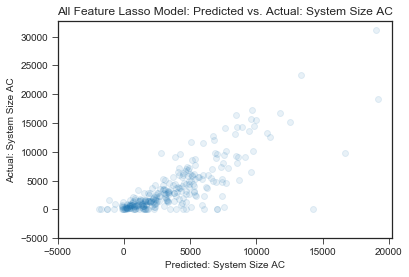

In [76]:
# plot predicted vs actual

plt.scatter(test_set_pred_5,y_test,alpha=.1)
plt.xlim(-5000)
plt.ylim(-5000)
plt.xlabel('Predicted: System Size AC')
plt.ylabel('Actual: System Size AC')
plt.title('All Feature Lasso Model: Predicted vs. Actual');

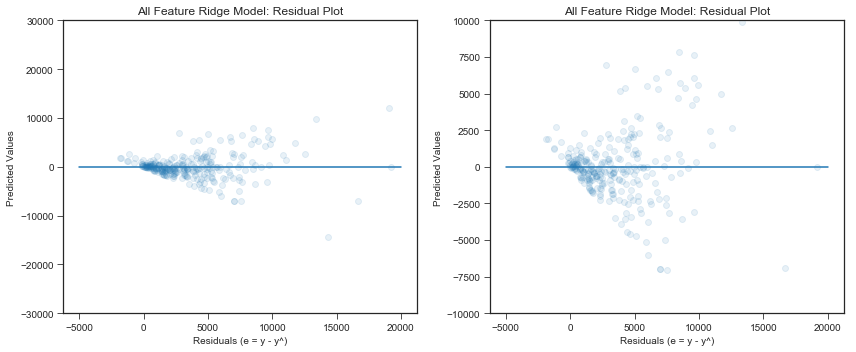

In [77]:
# residual plot(s) shown on two different ylim scales
# note: these residuals are Unbiased, but Heteroscadastic.
# The SD is small to the left of the plot and large to the right: the residuals are heteroscadastic.
# http://condor.depaul.edu/sjost/it223/documents/regress.htm

plt.subplots(1,2, figsize=(12,5))
plt.subplot(121)

plt.scatter(test_set_pred_5,y_test-test_set_pred_5,alpha=.1)
plt.title('All Feature Ridge Model: Residual Plot')
plt.plot(np.linspace(-5000,20000,1000),np.linspace(0,0,1000))
plt.ylim(-30000,30000)
plt.xlabel('Residuals (e = y - y^)')
plt.ylabel('Predicted Values');

plt.subplot(122)
plt.scatter(test_set_pred_5,y_test-test_set_pred_5,alpha=.1)
plt.title('All Feature Ridge Model: Residual Plot')
plt.plot(np.linspace(-5000,20000,1000),np.linspace(0,0,1000))
plt.ylim(-10000,10000)
plt.xlabel('Residuals (e = y - y^)')
plt.ylabel('Predicted Values');

plt.tight_layout()

In [78]:
# Final R^2 Test Score
r2_manual(y_test, test_set_pred_5)

0.6497258582926582

In [153]:
# Final RMSE Test Score
rmse_manual(y_test, test_set_pred_5)

2615.464582462404

# Ensemble Tree-Based Regression Modeling

## Random Forrest Regression

In [80]:
# cross-validate RandomForrestRegressor on all-variables

# use a full grid over all parameters
param_grid_rf = {"n_estimators": [100, 200, 400, 800],
              "max_depth": [3, 5, 10, None],
              "max_features": [1, 3, 5, 10],
              "min_samples_split": [2, 5, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "random_state": [4444]}

# run grid search
grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid_rf, \
                                scoring='r2', cv=5, verbose=1, n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 34.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 400, 800], 'max_depth': [3, 5, 10, None], 'max_features': [1, 3, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [True, False], 'random_state': [4444]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [81]:
print(grid_search_rf.best_score_)
print(grid_search_rf.best_params_)

0.6040264005443464
{'bootstrap': False, 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 400, 'random_state': 4444}


In [82]:
# view cv_results
pd.DataFrame(grid_search_rf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.314944,0.012410,0.380765,0.477499,True,3,1,1,2,100,...,0.367878,0.475064,0.414347,0.465227,0.356490,0.490221,0.016520,0.004200,0.027133,0.009444
1,0.507900,0.018707,0.376429,0.472643,True,3,1,1,2,200,...,0.363821,0.476384,0.401145,0.460792,0.356849,0.482551,0.059275,0.001509,0.023589,0.008041
2,0.952192,0.038432,0.378935,0.471605,True,3,1,1,2,400,...,0.364923,0.477659,0.408090,0.457371,0.355300,0.481043,0.070020,0.008657,0.026553,0.008664
3,1.714142,0.067944,0.390796,0.481820,True,3,1,1,2,800,...,0.382158,0.488431,0.413494,0.467914,0.370258,0.492661,0.034775,0.004713,0.024905,0.009057
4,0.211252,0.009294,0.381660,0.477501,True,3,1,1,5,100,...,0.371505,0.475162,0.416498,0.464088,0.354759,0.489777,0.007441,0.000924,0.027859,0.009377
5,0.414082,0.017019,0.376527,0.471778,True,3,1,1,5,200,...,0.365903,0.475801,0.402318,0.458244,0.355274,0.481343,0.003125,0.001026,0.024063,0.009011
6,0.867251,0.042066,0.378969,0.471137,True,3,1,1,5,400,...,0.365584,0.476539,0.409036,0.456152,0.355941,0.481463,0.016060,0.008524,0.025942,0.009319
7,1.704464,0.065982,0.390650,0.480867,True,3,1,1,5,800,...,0.382199,0.487200,0.412548,0.465327,0.371082,0.492294,0.050539,0.001016,0.024371,0.009739
8,0.210590,0.009468,0.383333,0.477410,True,3,1,1,10,100,...,0.376217,0.477924,0.416075,0.462621,0.362788,0.493874,0.009377,0.001248,0.025118,0.011281
9,0.444847,0.022867,0.375418,0.469611,True,3,1,1,10,200,...,0.368077,0.474072,0.400204,0.456300,0.360104,0.481130,0.021183,0.005795,0.021744,0.009843


In [83]:
# view the best_estimator from GridSearchCV
grid_search_rf.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=400, n_jobs=1, oob_score=False, random_state=4444,
           verbose=0, warm_start=False)

In [85]:
# cross-validate RandomForrestRegression on all-variables

cv_results['rf'] = cross_validate(grid_search_rf.best_estimator_, X_train, y_train, \
                                    scoring='r2', cv=5, n_jobs=-1)

In [86]:
cv_results['rf']

{'fit_time': array([4.38579702, 4.30347228, 4.28843307, 4.27970982, 2.36936092]),
 'score_time': array([0.04733992, 0.06077886, 0.07999325, 0.05893612, 0.02303195]),
 'test_score': array([0.73223308, 0.57255144, 0.53616136, 0.59423699, 0.58480125]),
 'train_score': array([0.96502454, 0.9726438 , 0.97533131, 0.97511875, 0.9663641 ])}

In [87]:
# print avg cv_results thus far

for k,v in cv_results.items():
    print(k)
    print()
    for key,value in v.items():
        print("{}: avg {}".format(key,round(value.mean(),3)))
    print()
    print()

lr_1

fit_time: avg 0.035
score_time: avg 0.001
test_score: avg 0.158
train_score: avg 0.172


lr_2

fit_time: avg 0.017
score_time: avg 0.003
test_score: avg 0.235
train_score: avg 0.259


lr_3

fit_time: avg 0.015
score_time: avg 0.003
test_score: avg 0.553
train_score: avg 0.648


lr_4

fit_time: avg 0.034
score_time: avg 0.001
test_score: avg 0.562
train_score: avg 0.638


lr_5

fit_time: avg 0.007
score_time: avg 0.001
test_score: avg 0.564
train_score: avg 0.634


rf

fit_time: avg 3.925
score_time: avg 0.054
test_score: avg 0.604
train_score: avg 0.971




In [88]:
rf = grid_search_rf.best_estimator_
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=400, n_jobs=1, oob_score=False, random_state=4444,
           verbose=0, warm_start=False)

In [89]:
# feature importance scores

feature_import_rf = pd.DataFrame(data=rf.feature_importances_, index=X.columns.values, columns=['values'])
feature_import_rf.sort_values(['values'], ascending=False, inplace=True)
feature_import_rf

,values
yearly_sunlight_kwh_s,0.120219
number_of_panels_s,0.109556
yearly_sunlight_kwh_e,0.095194
number_of_panels_w,0.076902
yearly_sunlight_kwh_w,0.050895
Land Area,0.047951
number_of_panels_e,0.044849
yearly_sunlight_kwh_median,0.032354
number_of_panels_median,0.026354
kw_median,0.024436


In [90]:
feature_import_rf.reset_index(level=0, inplace=True)

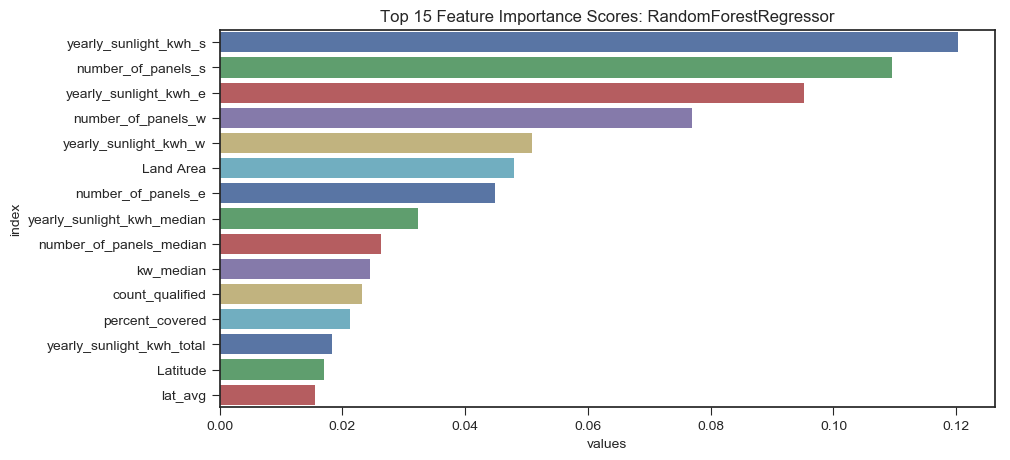

In [123]:
# bar plot feature importance scores
fig, ax = plt.subplots(figsize=(10,5), facecolor = 'white', dpi=100)
sns.barplot(x='values', y='index', data=feature_import_rf[:15], palette='deep', ax=ax)
plt.title('Top 15 Feature Importance Scores: RandomForestRegressor')
plt.show()
fig.tight_layout()

In [92]:
# get the predictions on the test set
test_set_pred_rf = rf.predict(X_test)

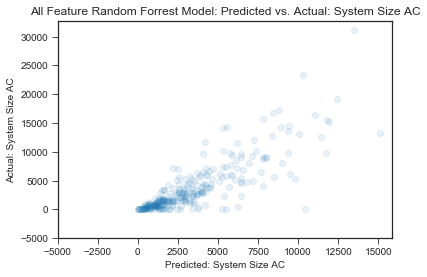

In [93]:
# plot predicted vs actual

plt.scatter(test_set_pred_rf,y_test,alpha=.1)
plt.xlim(-5000)
plt.ylim(-5000)
plt.xlabel('Predicted: System Size AC')
plt.ylabel('Actual: System Size AC')
plt.title('All Feature Random Forrest Model: Predicted vs. Actual');

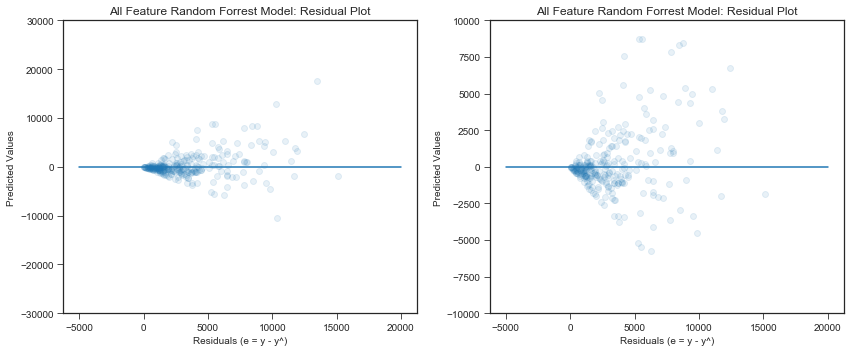

In [94]:
# residual plot(s) shown on two different ylim scales
# note: these residuals are Unbiased, but Heteroscadastic.
# The SD is small to the left of the plot and large to the right: the residuals are heteroscadastic.
# http://condor.depaul.edu/sjost/it223/documents/regress.htm

plt.subplots(1,2, figsize=(12,5))
plt.subplot(121)

plt.scatter(test_set_pred_rf,y_test-test_set_pred_rf,alpha=.1)
plt.title('All Feature Random Forrest Model: Residual Plot')
plt.plot(np.linspace(-5000,20000,1000),np.linspace(0,0,1000))
plt.ylim(-30000,30000)
plt.xlabel('Residuals (e = y - y^)')
plt.ylabel('Predicted Values');

plt.subplot(122)
plt.scatter(test_set_pred_rf,y_test-test_set_pred_rf,alpha=.1)
plt.title('All Feature Random Forrest Model: Residual Plot')
plt.plot(np.linspace(-5000,20000,1000),np.linspace(0,0,1000))
plt.ylim(-10000,10000)
plt.xlabel('Residuals (e = y - y^)')
plt.ylabel('Predicted Values');

plt.tight_layout()

In [95]:
# Final R^2 Test Score
r2_manual(y_test, test_set_pred_rf)

0.6493104710088202

In [154]:
# Final RMSE Test Score
rmse_manual(y_test, test_set_pred_rf)

2617.0149521486615

## XGBoost Regression

In [98]:
# cross-validate XGBoostRegressor on all-variables

# use a full grid over all parameters
param_grid_xgb = {
    "learning_rate": [0.05,0.1],
    "max_depth": [4,6,8],
    "min_child_weight": [1,3,5],
    "subsample": [0.6,0.8,1],
    "gamma": [0,0.2,0.4],
    "colsample_bytree": [0.6,0.8,1],
    "n_estimators": [100,250,500,1000],
    "random_state": [4444]
}

# run grid search
grid_search_xgb = GridSearchCV(XGBRegressor(), param_grid=param_grid_xgb, \
                                scoring='r2', cv=5, verbose=1, n_jobs=-1)

grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 44.8min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 55.3min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 67.9min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 83.0min
[Parallel(n_jobs=-1)]: Done 9720 out of 9720 | elapsed: 99.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [4, 6, 8], 'min_child_weight': [1, 3, 5], 'subsample': [0.6, 0.8, 1], 'gamma': [0, 0.2, 0.4], 'colsample_bytree': [0.6, 0.8, 1], 'n_estimators': [100, 250, 500, 1000], 'random_state': [4444]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=1)

In [99]:
print(grid_search_xgb.best_score_)
print(grid_search_xgb.best_params_)

0.666605999909136
{'colsample_bytree': 1, 'gamma': 0.4, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 1000, 'random_state': 4444, 'subsample': 0.6}


In [100]:
# view cv_results
pd.DataFrame(grid_search_xgb.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.399583,0.013218,0.621545,0.941339,0.6,0,0.05,4,1,100,...,0.571706,0.942434,0.575260,0.940336,0.599129,0.940944,0.010817,0.010926,0.071632,8.807380e-04
1,0.428106,0.002104,0.615845,0.953746,0.6,0,0.05,4,1,100,...,0.554345,0.955144,0.589672,0.952130,0.599300,0.954376,0.008502,0.001456,0.063807,1.008050e-03
2,0.516540,0.016624,0.603593,0.960598,0.6,0,0.05,4,1,100,...,0.576278,0.962693,0.585352,0.959036,0.555568,0.959210,0.054881,0.030189,0.066814,1.359169e-03
3,1.051358,0.002977,0.639517,0.989679,0.6,0,0.05,4,1,250,...,0.588360,0.989902,0.558537,0.990722,0.630988,0.989829,0.032237,0.000574,0.080628,9.507036e-04
4,1.164495,0.002802,0.638581,0.992335,0.6,0,0.05,4,1,250,...,0.576394,0.992858,0.590334,0.992460,0.630307,0.992429,0.046274,0.000524,0.066011,3.417290e-04
5,1.406132,0.002648,0.623526,0.991513,0.6,0,0.05,4,1,250,...,0.577092,0.992543,0.593140,0.991982,0.584027,0.992142,0.029424,0.000511,0.069028,1.235891e-03
6,1.672714,0.012941,0.644359,0.999019,0.6,0,0.05,4,1,500,...,0.588095,0.999100,0.561462,0.999069,0.637671,0.999053,0.142645,0.009027,0.083112,1.320003e-04
7,1.727887,0.006322,0.641902,0.999307,0.6,0,0.05,4,1,500,...,0.575982,0.999381,0.591947,0.999324,0.633257,0.999303,0.059194,0.001719,0.067306,4.397991e-05
8,1.950492,0.004771,0.628971,0.999019,0.6,0,0.05,4,1,500,...,0.576501,0.999202,0.596084,0.999211,0.589680,0.998918,0.057583,0.000131,0.070538,2.229095e-04
9,2.941083,0.012356,0.644477,0.999984,0.6,0,0.05,4,1,1000,...,0.586210,0.999985,0.561239,0.999986,0.637608,0.999983,0.058183,0.004002,0.083981,2.020477e-06


In [101]:
# view the best_estimator from GridSearchCV
grid_search_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.4, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=4444,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

In [102]:
# cross-validate RandomForrestRegression on all-variables

cv_results['xgb'] = cross_validate(grid_search_xgb.best_estimator_, X_train, y_train, \
                                    scoring='r2', cv=5, n_jobs=-1)

In [103]:
cv_results['xgb']

{'fit_time': array([3.77950311, 3.82466507, 3.81024122, 3.88284588, 1.95729303]),
 'score_time': array([0.01071095, 0.01280999, 0.01514792, 0.00866199, 0.00644207]),
 'test_score': array([0.80070298, 0.67367349, 0.58847841, 0.5879334 , 0.68236294]),
 'train_score': array([0.99998835, 0.999987  , 0.9999898 , 0.99998837, 0.99998966])}

In [104]:
# print avg cv_results thus far

for k,v in cv_results.items():
    print(k)
    print()
    for key,value in v.items():
        print("{}: avg {}".format(key,round(value.mean(),3)))
    print()
    print()

lr_1

fit_time: avg 0.035
score_time: avg 0.001
test_score: avg 0.158
train_score: avg 0.172


lr_2

fit_time: avg 0.017
score_time: avg 0.003
test_score: avg 0.235
train_score: avg 0.259


lr_3

fit_time: avg 0.015
score_time: avg 0.003
test_score: avg 0.553
train_score: avg 0.648


lr_4

fit_time: avg 0.034
score_time: avg 0.001
test_score: avg 0.562
train_score: avg 0.638


lr_5

fit_time: avg 0.007
score_time: avg 0.001
test_score: avg 0.564
train_score: avg 0.634


rf

fit_time: avg 3.925
score_time: avg 0.054
test_score: avg 0.604
train_score: avg 0.971


xgb

fit_time: avg 3.451
score_time: avg 0.011
test_score: avg 0.667
train_score: avg 1.0




In [105]:
xgb = grid_search_xgb.best_estimator_
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.4, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=4444,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6)

In [106]:
# feature importance scores

feature_import_xgb = pd.DataFrame(data=xgb.feature_importances_, index=X.columns.values, columns=['values'])
feature_import_xgb.sort_values(['values'], ascending=False, inplace=True)
feature_import_xgb

,values
Population,0.056239
Income Per Household,0.042292
Land Area,0.041842
Business Annual Payroll,0.039367
percent_covered,0.038542
Latitude,0.038242
Persons Per Household,0.034268
percent_qualified,0.033293
Median Age,0.030969
Longitude,0.029994


In [107]:
feature_import_xgb.reset_index(level=0, inplace=True)

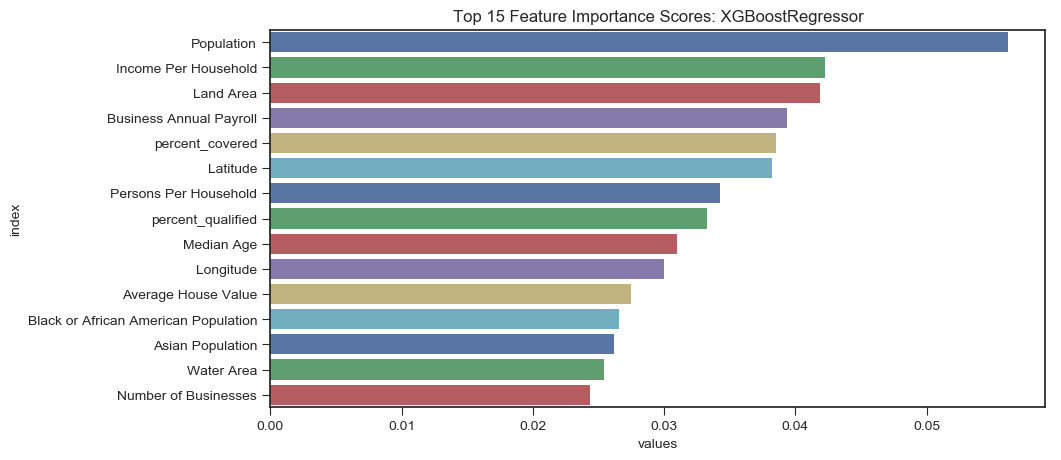

In [122]:
# bar plot feature importance scores
fig, ax = plt.subplots(figsize=(10,5), facecolor = 'white', dpi=100)
sns.barplot(x='values', y='index', data=feature_import_xgb[:15], palette='deep', ax=ax)
plt.title('Top 15 Feature Importance Scores: XGBoostRegressor')
plt.show()
fig.tight_layout()

In [109]:
# get the predictions on the test set
test_set_pred_xgb = xgb.predict(X_test)

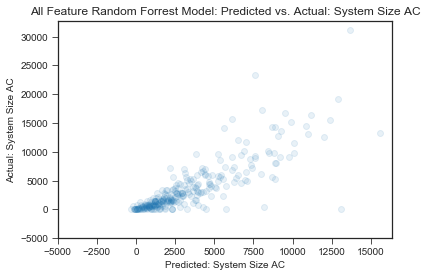

In [110]:
# plot predicted vs actual

plt.scatter(test_set_pred_xgb,y_test,alpha=.1)
plt.xlim(-5000)
plt.ylim(-5000)
plt.xlabel('Predicted: System Size AC')
plt.ylabel('Actual: System Size AC')
plt.title('All Feature XGBoostRegressor Model: Predicted vs. Actual');

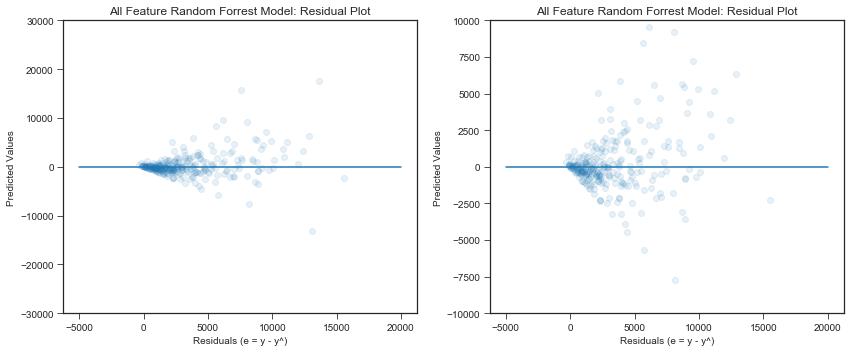

In [111]:
# residual plot(s) shown on two different ylim scales
# note: these residuals are Unbiased, but Heteroscadastic.
# The SD is small to the left of the plot and large to the right: the residuals are heteroscadastic.
# http://condor.depaul.edu/sjost/it223/documents/regress.htm

plt.subplots(1,2, figsize=(12,5))
plt.subplot(121)

plt.scatter(test_set_pred_xgb,y_test-test_set_pred_xgb,alpha=.1)
plt.title('All Feature XGBoostRegressor Model: Residual Plot')
plt.plot(np.linspace(-5000,20000,1000),np.linspace(0,0,1000))
plt.ylim(-30000,30000)
plt.xlabel('Residuals (e = y - y^)')
plt.ylabel('Predicted Values');

plt.subplot(122)
plt.scatter(test_set_pred_xgb,y_test-test_set_pred_xgb,alpha=.1)
plt.title('All Feature XGBoostRegressor Model: Residual Plot')
plt.plot(np.linspace(-5000,20000,1000),np.linspace(0,0,1000))
plt.ylim(-10000,10000)
plt.xlabel('Residuals (e = y - y^)')
plt.ylabel('Predicted Values');

plt.tight_layout()

In [112]:
# Final R^2 Test Score
r2_manual(y_test, test_set_pred_xgb)

0.6553359294376363

In [155]:
# Final RMSE Test Score
rmse_manual(y_test, test_set_pred_xgb)

2594.435098430967

# Diagnostic Plots

In [140]:
def diagnostic_plot(x, y, y_predict):
    
    plt.figure(figsize=(20,5))
    
    plt.subplot(1,2,1)
    y_predict = np.array(y_predict).reshape(-1)
    y_predict.shape
    res = y - y_predict #pred
    plt.scatter(y_predict, res)
    plt.ylim(-15000,25000)
    plt.plot(np.linspace(-5000,25000,1000),np.linspace(0,0,1000))
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1,2,2)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.ylim(-15000,25000)
    plt.title("Normal Q-Q plot")
    
    plt.tight_layout()

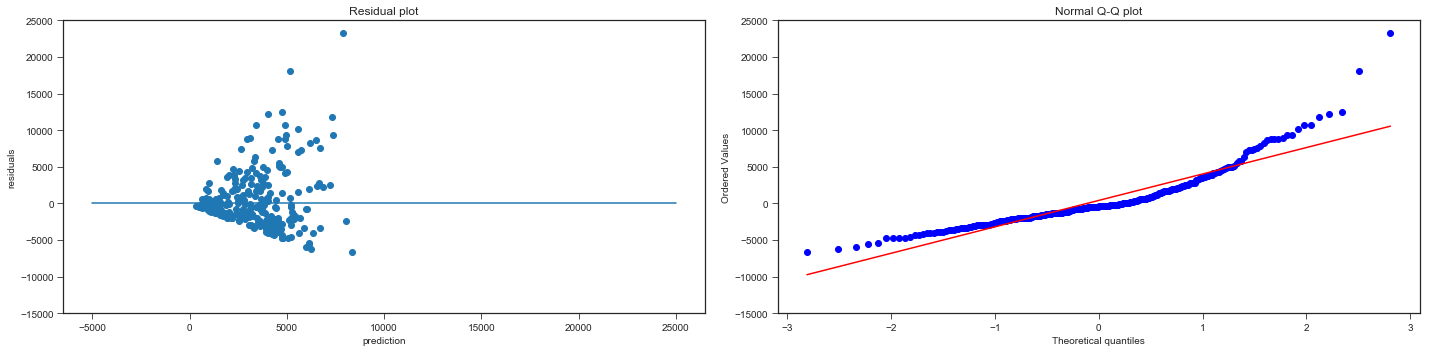

In [141]:
diagnostic_plot(X_test, y_test, test_set_pred_1)

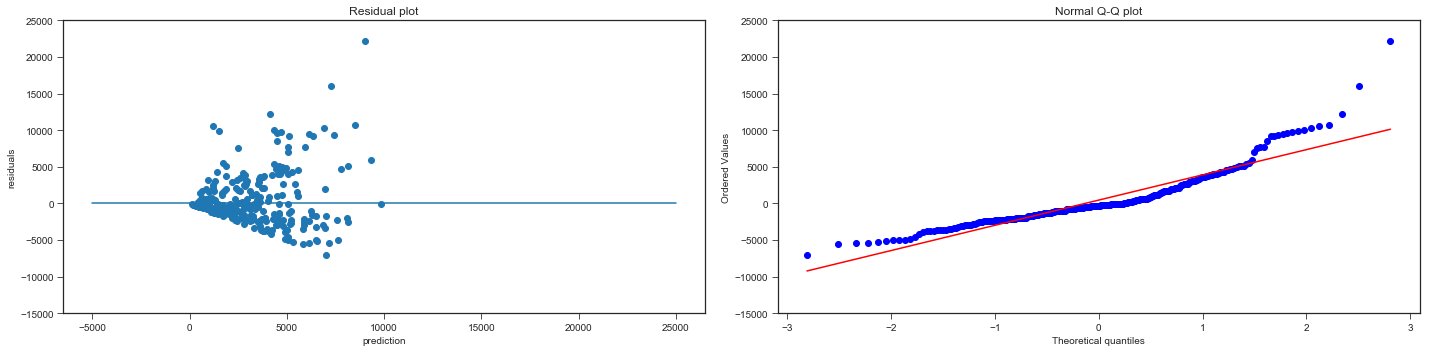

In [142]:
diagnostic_plot(X_test, y_test, test_set_pred_2)

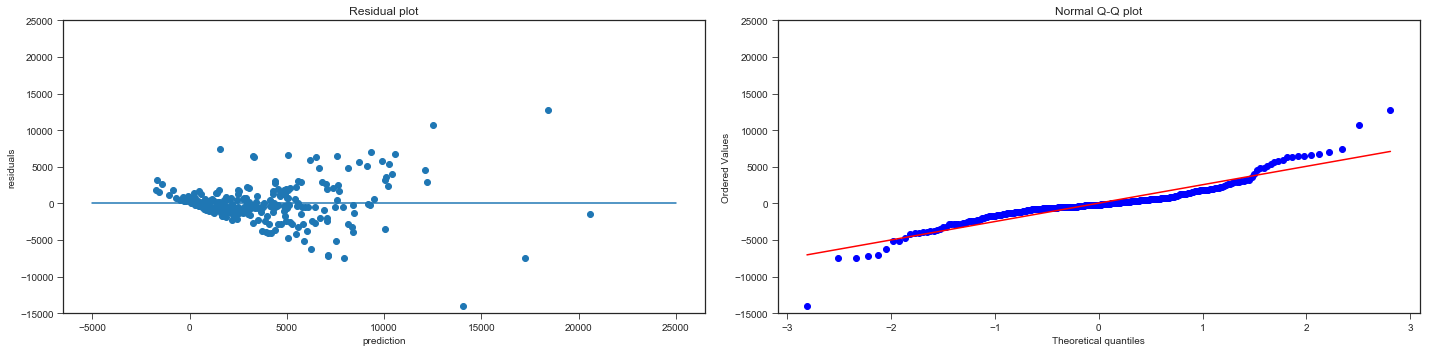

In [143]:
diagnostic_plot(X_test, y_test, test_set_pred_3)

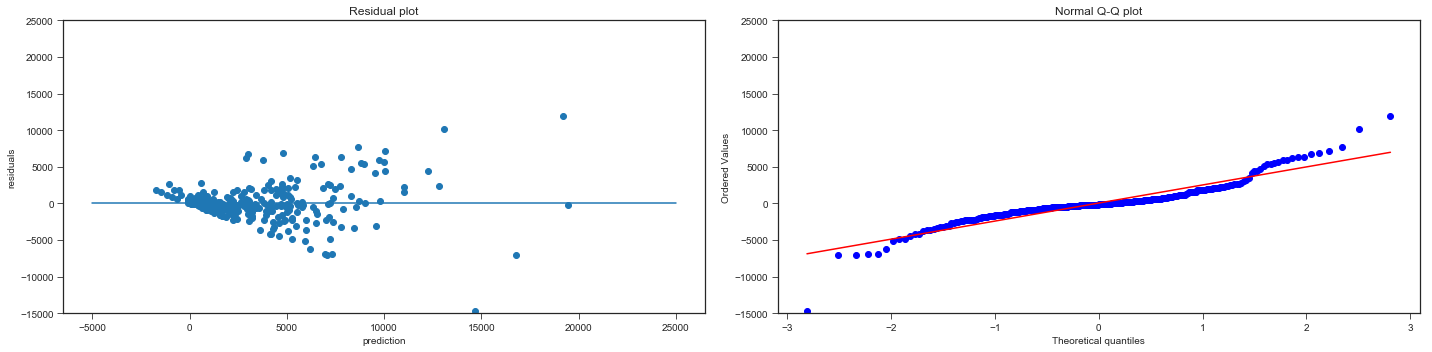

In [144]:
diagnostic_plot(X_test, y_test, test_set_pred_4)

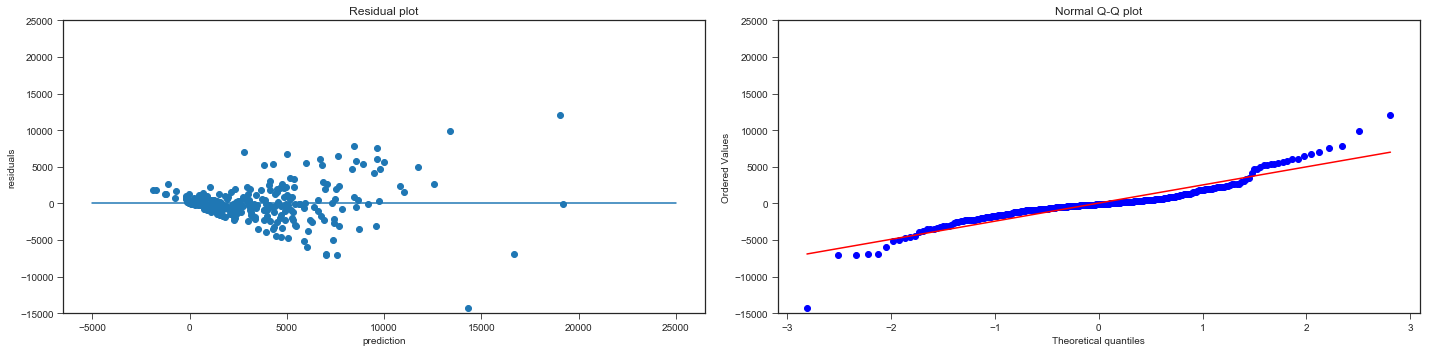

In [145]:
diagnostic_plot(X_test, y_test, test_set_pred_5)

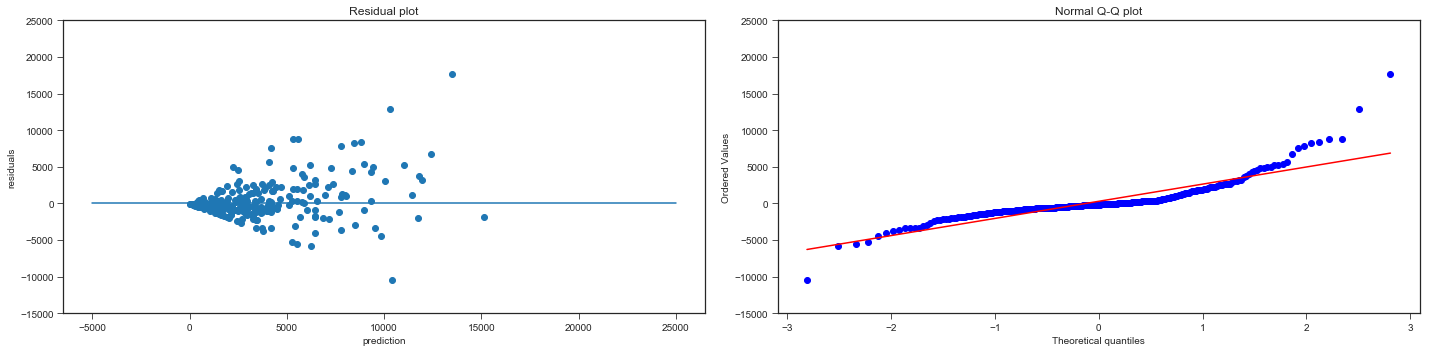

In [146]:
diagnostic_plot(X_test, y_test, test_set_pred_rf)

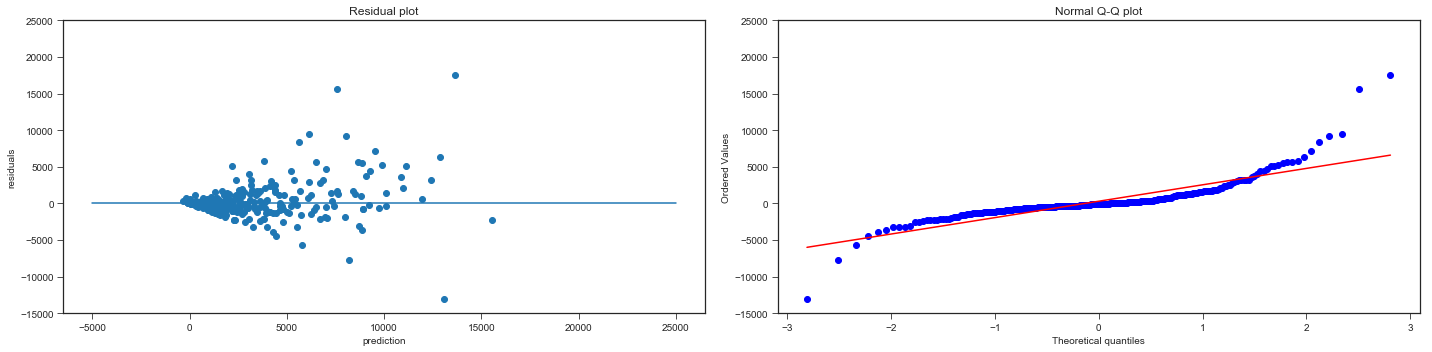

In [147]:
diagnostic_plot(X_test, y_test, test_set_pred_xgb)